porównanie

In [76]:
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, rc
from scipy.stats import chisquare, kstest, norm, levene, ttest_ind, boxcox
from scipy.stats import probplot, kurtosis, skew, spearmanr, wilcoxon, chi2_contingency
from scipy.stats import mannwhitneyu, kruskal, pearsonr, ttest_rel, f_oneway
import pylab
import statsmodels.api as sm
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
from matplotlib.colors import LogNorm, Normalize
from PIL import Image
import os
import joblib

In [77]:
np.random.seed(seed=1)

funkcje z compare.ipynb

In [78]:
def load_from_file(filename):
    file = open(filename, 'r')
    data = json.load(file)
    file.close()
    return data


def cube_list2array(d):
    d['cube'] = np.asarray(d['cube'])


def trim_cube(d, sh):
    if d['cube'].shape != sh:
        print("trimming")
        print("shape", d['cube'].shape)
        d['cube'] = d['cube'][:sh[0], :sh[1], :sh[2]]
        print("shape", d['cube'].shape)


def load_from_filename_list(fn_list):
    cube_list = []
    for fn in fn_list:
        cube = load_from_file(fn)
        cube_list2array(cube)
        trim_cube(cube, (180, 180, 240))
        cube_list.append(cube)
    return cube_list


def cube_by_name(all_cubes, name):
    for i in range(len(all_cubes)):
        if all_cubes[i]['name'] == name:
            return all_cubes[i]
    return None


# próba kontrolna
def add_random_cube(all_cubes):
    if all_cubes[0]['name'] == 'random_cube':
        print('ta seria ma już random_cube!')
    else:
        c = all_cubes[0]['cube'] # my params
        sh0 = len(c)
        sh1 = len(c[0])
        sh2 = len(c[0][0])
        cube_shape = [sh0, sh1, sh2]
        cb = cube_shape

        random_arr = np.random.rand(cb[0], cb[1], cb[2])
        s = np.sum(random_arr)
        n_random_photons = 100_000_000
        random_arr *= n_random_photons
        random_arr /= s

        c2 = all_cubes[0]
        random_cube = {
            "n_photons": n_random_photons,
            "overflow": 0,
            "mu_a": 1.673,
            "name": 'random_cube',
            "bins_per_1_cm": c2['bins_per_1_cm'],
            "cube": random_arr,
            "photon_weight": 1.0,
            "normalized_already": False,
            "file_path": "NA",
            "file_dir_path": "NA",
            "params_type": "org_my"
        }

        print(random_arr.size)
        print(random_arr.shape)
        print(random_arr.sum())

        all_cubes.insert(0, random_cube)


def filter_outliers(arr, q_min=0.01, q_max=0.99):
    arr = arr.copy()
    if True:
        qqmin = np.quantile(arr, q=q_min)
        qqmax = np.quantile(arr, q=q_max)
        main_ids_out = np.logical_or( (arr < qqmin),  (arr > qqmax) )
        s = np.sum(main_ids_out)
        val_replace = np.random.choice(arr.flatten(), s)
        temp_arr = val_replace
        while True:
            ids_out = np.logical_or( (temp_arr < qqmin), (temp_arr > qqmax) )
            s = np.sum(ids_out)
            if s == 0:
                arr[main_ids_out] = temp_arr
                break
            val_replace = np.random.choice(arr.flatten(), s)
            temp_arr[ids_out] = val_replace
    return arr


def simple_hist_plot(arr, range, bins, title="", density=False, norm=False):
    # plt.hist(arr, range=range, bins=bins, density=density)
    # # plt.yscale("log") # - tutaj dopisać title i opisy osi
    # plt.grid()
    # plt.show() #  - zakomentować to
    
    hist, bin_edges = np.histogram(arr, range=range, bins=bins, density=density)
    plt.bar(bin_edges[:-1], hist, width=(bin_edges[1] - bin_edges[0]) * 1.0) # , color='b'
    # plt.plot(bin_edges[:-1], hist, c='r')
    plt.title('Histogram'+title)
    plt.xlabel('transport')
    plt.ylabel('ilość próbek')
    if norm == "log":
        plt.yscale("log")
    plt.grid()
    plt.show()


def simple_boxplot(arr, title=""):
    plt.boxplot(arr)
    plt.title('Boxplot'+title)
    plt.grid()
    plt.show()


def filter_zeros(arr, typ=None):
    arr = arr.copy()
    arr[arr == 0] = np.min(arr[arr > 0])
    return arr


def fun_tan(arr, typ=None):
    return -np.tan(arr - np.pi / 2)


def fun_tan_wrapper(arr, typ): # łamana
    arr = arr.copy()
    global max_my
    global max_org
    global brpoint_my
    global brpoint_org

    if typ is None:
        raise ValueError('Potrzebny typ parametrów danych')
    
    if 'org' in typ:
        maxi_all = max_org
        brpoint = brpoint_org
    elif 'my' in typ:
        maxi_all = max_my
        brpoint = brpoint_my
    else:
        raise ValueError('Potrzebny typ parametrów danych')

    # dane od 0 do brpoint trzeba rozciągnąć na zakres 0 do pi/4
    # tan(pi/4) = 1
    arr = arr.copy()
    new_arr = arr.copy()
    new_arr[arr <= brpoint] = new_arr[arr <= brpoint] / brpoint * np.pi/4

    # dane od brpoint do maxi_all trzeba rozciągnąć na zakres od pi/4 do pi/2
    new_arr[arr > brpoint] = (new_arr[arr > brpoint] - brpoint) / (maxi_all-brpoint) * (np.pi/2 - np.pi/4) + np.pi/4

    arr = new_arr
    arr = fun_tan(arr)

    return arr


def move_mean(arr):
    arr = arr.copy()
    mea = np.mean(arr)
    arr = arr - mea
    return arr


def move_std(arr):
    arr = arr.copy()
    mea = np.mean(arr)
    st = np.std(arr)
    arr = arr - mea
    arr = arr / st
    arr = arr + mea
    return arr


def move_mean_std(arr):
    arr = arr.copy()
    mea = np.mean(arr)
    st = np.std(arr)
    arr = arr - mea
    arr = arr / st
    return arr


def dump_transformers():

    model_dir = 'models'
    files = os.listdir(model_dir)
    files = [model_dir+'/'+fn for fn in files]
    print(files)

    global org_quantile_transformer
    global org_power_transformer
    global org_global_training_arr
    global my_quantile_transformer
    global my_power_transformer
    global my_global_training_arr

    # Ścieżki do zapisania modeli
    org_quantile_transformer_filename = 'models/org_quantile_transformer.pkl'
    org_power_transformer_filename = 'models/org_power_transformer.pkl'
    org_global_training_arr_filename = 'models/org_global_training_arr.pkl'
    my_quantile_transformer_filename = 'models/my_quantile_transformer.pkl'
    my_power_transformer_filename = 'models/my_power_transformer.pkl'
    my_global_training_arr_filename = 'models/my_global_training_arr.pkl'

    # Zapisanie modeli za pomocą joblib
    if org_quantile_transformer is not None and (org_quantile_transformer_filename not in files):
        joblib.dump(org_quantile_transformer, org_quantile_transformer_filename)
    if org_power_transformer is not None and (org_power_transformer_filename not in files):
        joblib.dump(org_power_transformer, org_power_transformer_filename)
    if org_global_training_arr is not None and (org_global_training_arr_filename not in files):
        joblib.dump(org_global_training_arr, org_global_training_arr_filename)
    if my_quantile_transformer is not None and (my_quantile_transformer_filename not in files):
        joblib.dump(my_quantile_transformer, my_quantile_transformer_filename)
    if my_power_transformer is not None and (my_power_transformer_filename not in files):
        joblib.dump(my_power_transformer, my_power_transformer_filename)
    if my_global_training_arr is not None and (my_global_training_arr_filename not in files):
        joblib.dump(my_global_training_arr, my_global_training_arr_filename)


def load_transformers():

    model_dir = 'models'
    files = os.listdir(model_dir)
    files = [model_dir+'/'+fn for fn in files]
    print(files)

    loaded = 0

    global org_quantile_transformer
    global org_power_transformer
    global org_global_training_arr
    global my_quantile_transformer
    global my_power_transformer
    global my_global_training_arr

    # Ścieżki do zapisania modeli
    org_quantile_transformer_filename = 'models/org_quantile_transformer.pkl'
    org_power_transformer_filename = 'models/org_power_transformer.pkl'
    org_global_training_arr_filename = 'models/org_global_training_arr.pkl'
    my_quantile_transformer_filename = 'models/my_quantile_transformer.pkl'
    my_power_transformer_filename = 'models/my_power_transformer.pkl'
    my_global_training_arr_filename = 'models/my_global_training_arr.pkl'

    if org_quantile_transformer is None and (org_quantile_transformer_filename in files):
        org_quantile_transformer = joblib.load(org_quantile_transformer_filename)
        loaded += 1
    if org_power_transformer is None and (org_power_transformer_filename in files):
        org_power_transformer = joblib.load(org_power_transformer_filename)
        loaded += 1
    if org_global_training_arr is None and (org_global_training_arr_filename in files):
        org_global_training_arr = joblib.load(org_global_training_arr_filename)
        loaded += 1
    if my_quantile_transformer is None and (my_quantile_transformer_filename in files):
        my_quantile_transformer = joblib.load(my_quantile_transformer_filename)
        loaded += 1
    if my_power_transformer is None and (my_power_transformer_filename in files):
        my_power_transformer = joblib.load(my_power_transformer_filename)
        loaded += 1
    if my_global_training_arr is None and (my_global_training_arr_filename in files):
        my_global_training_arr = joblib.load(my_global_training_arr_filename)
        loaded += 1

    print(f'loaded num {loaded}')
    if loaded < 6:
        return False
    elif loaded == 6:
        return True
    else:
        raise NotImplementedError()


def train_data_transformers(init_arr = None):

    if load_transformers():
        return True

    global quantile_transformer
    global power_transformer
    global global_training_arr

    if quantile_transformer is None or power_transformer is None: # tutaj obsługowany
        # jest wyjątek braku ustawienia wcześniej transformerów globalnych
        if global_training_arr is None:
            if init_arr is None:
                raise Exception('Tablica treningowa nie została wcześniej ustawiona ani podana jako argument tej funkcji.')
            else:
                arr = init_arr.flatten()
                arr = np.sort(arr)
                arr = filter_outliers(arr)
                global_training_arr = arr
    else:
        print('Wszystkie transformery zostały przetrenowane wcześniej.')

    if quantile_transformer is None:
        print('Trenowanie quantile transformer.')
        rng = np.random.RandomState(304)
        # n_quantiles is set to the training set size rather than the default value
        # to avoid a warning being raised by this example
        n_quantiles = global_training_arr.shape[0]
        n_quantiles = 1_000_000
        subsample = n_quantiles
        qt = QuantileTransformer(
        n_quantiles=n_quantiles, output_distribution="normal", random_state=rng, subsample=subsample
        )
        quantile_transformer = qt.fit(global_training_arr.reshape(-1, 1))
        print('Training quantile transformer done.')

    if power_transformer is None:
        print('Trenowanie power transformer.')
        rng = np.random.RandomState(304)
        pt = PowerTransformer(method='yeo-johnson')
        power_transformer = pt.fit(global_training_arr.reshape(-1, 1))
        print('Training power transformer done.')


def setup_transformers(all_cubes):
    # wczytaj lub wytrenuj i zapisz

    global quantile_transformer
    global power_transformer
    global global_training_arr

    global org_quantile_transformer
    global org_power_transformer
    global org_global_training_arr
    global my_quantile_transformer
    global my_power_transformer
    global my_global_training_arr

    quantile_transformer = None
    power_transformer = None
    global_training_arr = None

    org_quantile_transformer = None
    org_power_transformer = None
    org_global_training_arr = None
    my_quantile_transformer = None
    my_power_transformer = None
    my_global_training_arr = None

    if load_transformers():
        return True

    train_arr = cube_by_name(all_cubes, 'mc456_my_100mln_cube')['cube']
    train_data_transformers(init_arr = train_arr)
    my_quantile_transformer = quantile_transformer
    my_power_transformer = power_transformer
    my_global_training_arr = global_training_arr
    quantile_transformer = None
    power_transformer = None
    global_training_arr = None
    print('my', my_quantile_transformer)
    print('empty', quantile_transformer)

    train_arr = cube_by_name(all_cubes, 'mc456_org_100mln_cube')['cube']
    train_data_transformers(init_arr = train_arr)
    org_quantile_transformer = quantile_transformer
    org_power_transformer = power_transformer
    org_global_training_arr = global_training_arr
    quantile_transformer = None
    power_transformer = None
    global_training_arr = None

    dump_transformers()


def ttest_preprocess(arr: np.ndarray, typ, dec=1):

    global org_power_transformer
    global my_power_transformer
    global org_quantile_transformer
    global my_quantile_transformer

    arr = arr.flatten()

    if dec == -1:
        return arr

    arr = filter_outliers(arr)

    if dec == 0:
        return arr

    if dec == 1:
        arr = filter_zeros(arr)
        arr = np.log(arr) # najlepszy boxcox lambda = 0, więc lepiej logarytm
        return arr

    if dec == 2:
        arr = fun_tan_wrapper(arr, typ) # przeskalowany logarytm
        return arr

    if dec == 3:
        if 'org' in typ:
            transformer = org_power_transformer
        elif 'my' in typ:
            transformer = my_power_transformer
        transformed_data = transformer.transform(arr.reshape(-1, 1)).reshape(-1)
        arr = transformed_data.flatten()
        return arr

    if dec == 4:
        if 'org' in typ:
            transformer = org_quantile_transformer
        elif 'my' in typ:
            transformer = org_quantile_transformer
        transformed_data = transformer.transform(arr.reshape(-1, 1)).reshape(-1)
        arr = transformed_data.flatten()
        return arr
    
    raise NotImplementedError('Nie ma takiego dec')


def print_stats(cub_list, cub_arr_list=None, csv_out='print_stats_dump.csv'):
    header_text = f"{'Name' : >60}{'Sum' : >30}{'Avg' : >30}"
    header_text += f"{'ks_normal' : >30}{'ks_normal pval' : >30}"
    header_text += f"{'ks_normal log' : >30}{'ks_normal log pval' : >30}"
    header_text += f"{'ks_normal tan' : >30}{'ks_normal tan pval' : >30}"
    header_text += f"{'ks yeo-johnson' : >30}{'ks yeo-johnson pval' : >30}"
    header_text += f"{'ks quantile' : >30}{'ks quantile pval' : >30}"
    header_text += f"{'skew' : >30}{'kurtosis' : >30}"
    header_text += f"{'q0' : >30}{'q0_25' : >30}{'q0_50' : >30}"
    header_text += f"{'q0_75' : >30}{'q1' : >30}{'std' : >30}"
    header_text += f"{'variance' : >30}{'Overflow' : >30}{'perc. in' : >30}"
    header_text += f"{'n_photons' : >30}{'non_zero_vals' : >30}{'zero_vals' : >30}"
    print(header_text)
    csv_list = ['Name', 'Sum', 'Avg']
    csv_list += ['ks_normal', 'ks_normal pval']
    csv_list += ['ks_normal log', 'ks_normal log pval']
    csv_list += ['ks_normal tan', 'ks_normal tan pval']
    csv_list += ['ks yeo-johnson', 'ks yeo-johnson pval']
    csv_list += ['ks quantile', 'ks quantile pval']
    csv_list += ['skew', 'kurtosis']
    csv_list += ['q0', 'q0_25', 'q0_50']
    csv_list += ['q0_75', 'q1', 'std']
    csv_list += ['variance', 'Overflow', 'perc_in']
    csv_list += ['n_photons', 'non_zero_vals', 'zero_vals']
    csv_text = ','.join(csv_list) + '\n'
    csv_list = []
    for i in range(len(cub_list)):
        cub = cub_list[i]
        if (cub_arr_list is None):
            cub_arr = cub['cube'].copy()
        else:
            cub_arr = cub_arr_list[i].copy()
        n_phot = cub['n_photons']
        ovf = cub['overflow']
        s = cub_arr.sum()
        avg = np.average(cub_arr)
        q0 = np.quantile(cub_arr, q=0.0)
        q0_25 = np.quantile(cub_arr, q=0.25)
        q0_50 = np.quantile(cub_arr, q=0.50)
        q0_75 = np.quantile(cub_arr, q=0.75)
        q1 = np.quantile(cub_arr, q=1.0)
        std = np.std(cub_arr)
        var = np.var(cub_arr)
        perc = s / (s + ovf) * 100
        non_zero_vals = cub_arr.size - np.isclose(cub_arr, 0).sum()
        zero_vals = cub_arr.size - non_zero_vals
        # testy na normalność
        # test 1
        data = ttest_preprocess(cub_arr, typ=cub['params_type'], dec=-1)
        data = move_mean_std(data)
        ks_normal_test = kstest(data, norm.cdf)
        ks_normal_test_pval = ks_normal_test.pvalue
        ks_normal_test = ks_normal_test.statistic
        # test 2
        data = ttest_preprocess(cub_arr, typ=cub['params_type'], dec=1)
        data = move_mean_std(data)
        ks_normal_test2 = kstest(data, norm.cdf)
        ks_normal_test2_pval = ks_normal_test2.pvalue
        ks_normal_test2 = ks_normal_test2.statistic
        # test 3
        data = ttest_preprocess(cub_arr, typ=cub['params_type'], dec=2)
        data = move_mean_std(data)
        ks_normal_test3 = kstest(data, norm.cdf)
        ks_normal_test3_pval = ks_normal_test3.pvalue
        ks_normal_test3 = ks_normal_test3.statistic
        # test 4
        data = ttest_preprocess(cub_arr, typ=cub['params_type'], dec=3)
        data = move_mean_std(data)
        ks_normal_test4 = kstest(data, norm.cdf)
        ks_normal_test4_pval = ks_normal_test4.pvalue
        ks_normal_test4 = ks_normal_test4.statistic
        # test 5
        data = ttest_preprocess(cub_arr, typ=cub['params_type'], dec=4)
        data = move_mean_std(data)
        ks_normal_test5 = kstest(data, norm.cdf)
        ks_normal_test5_pval = ks_normal_test5.pvalue
        ks_normal_test5 = ks_normal_test5.statistic
        # skośność
        ske = skew(cub_arr.flatten())
        # kurtoza
        kurt = kurtosis(cub_arr.flatten())
        val_text = f"{cub['name'] : >60}{s : >30,.2f}{avg : >30,.2f}"
        val_text += f"{ks_normal_test : >30,.2f}{ks_normal_test_pval : >30,.2f}"
        val_text += f"{ks_normal_test2 : >30,.2f}{ks_normal_test2_pval : >30,.2f}"
        val_text += f"{ks_normal_test3 : >30,.2f}{ks_normal_test3_pval : >30,.2f}"
        val_text += f"{ks_normal_test4 : >30,.2f}{ks_normal_test4_pval : >30,.2f}"
        val_text += f"{ks_normal_test5 : >30,.2f}{ks_normal_test5_pval : >30,.2f}"
        val_text += f"{ske : >30,.2f}{kurt : >30,.2f}"
        val_text += f"{q0 : >30,.2f}{q0_25 : >30,.2f}{q0_50 : >30,.2f}"
        val_text += f"{q0_75 : >30,.2f}{q1 : >30,.2f}{std : >30,.2f}"
        val_text += f"{var : >30,.2f}{ovf : >30,.2f}{perc : >30,.2f}"
        val_text += f"{n_phot : >30}{non_zero_vals : >30}{zero_vals : >30}"
        print(val_text)
        csv_list = []
        csv_list = [cub['name'], s, avg]
        csv_list += [ks_normal_test, ks_normal_test_pval]
        csv_list += [ks_normal_test2, ks_normal_test2_pval]
        csv_list += [ks_normal_test3, ks_normal_test3_pval]
        csv_list += [ks_normal_test4, ks_normal_test4_pval]
        csv_list += [ks_normal_test5, ks_normal_test5_pval]
        csv_list += [ske, kurt]
        csv_list += [q0, q0_25, q0_50]
        csv_list += [q0_75, q1, std]
        csv_list += [var, ovf, perc]
        csv_list += [n_phot, non_zero_vals, zero_vals]
        csv_list = [str(n) for n in csv_list]
        csv_text += ','.join(csv_list) + '\n'
        with open(csv_out, 'w') as f:
            f.write(csv_text)


def normalization(d):
    if d['normalized_already']:
        print('dane znormalizowano już wcześniej!')
    else:
        # bins_per_1_cm = 120
        # mu_a = 0.37
        # n_photons = 1_000_000
        # val = val * 4.67
        bin_size_in_cm = 1 / d['bins_per_1_cm']
        bin_volume = (bin_size_in_cm)**3
        multi = 1 / (d['n_photons'] * bin_volume * d['mu_a'])
        d['cube'] = d['cube'] * multi
        d['overflow'] = d['overflow'] * multi
        d['photon_weight'] = d['photon_weight'] * multi
        d['normalized_already'] = True


def small_stat_table(all_cubes):
    print(f"{'max' :>10}{'name' :>60}{'params_type' :>15}{'max val' :>20}{'zero_perc' :>20}")
    i = 0
    for c in all_cubes:
        arr = c['cube']
        arr = filter_outliers(arr)
        maxi = np.max(arr)
        zero_perc = np.sum(arr == 0) / arr.flatten().shape[0]
        print(f"{'max' :>10}{str(i)+' '+c['name'] :>60}{c['params_type'] :>15}{maxi :>20,.2f}{zero_perc :>20,.2f}")
        i += 1


def draw_raw_example(all_cubes, id=1, q_min=0.0, q_max=1.0):
    c = all_cubes[id]
    arr = c['cube']
    arr = arr.flatten()
    arr = filter_outliers(arr)
    print(c['name'])
    print('max_arr', np.max(arr))
    rng = (np.quantile(arr, q=q_min), np.quantile(arr, q=q_max))
    simple_hist_plot(arr, range=rng, bins=1000)
    simple_hist_plot(arr, range=rng, bins=1000, norm='log')
    simple_boxplot(arr)


def my_qq_plot(arr, postsampling=None, bins=None, title="", reg=True):
    bins = arr.shape[0] if bins is None else bins
    q_min = 1 / bins
    q_max = 1 - q_min
    cdf = np.linspace(q_min, q_max, bins, endpoint=True)
    quantiles = np.sort(arr)
    if bins != arr.shape[0]:
        step = arr.shape[0] / bins
        f_idx = np.arange(0, bins, 1) * step
        i_idx = np.round(f_idx)
        i_idx = i_idx.astype(int)
        quantiles = quantiles[i_idx]
    quantiles_normal = norm.ppf(cdf)
    if postsampling is not None:
        # step = quantiles.shape[0] / postsampling
        step_weights = -(quantiles[1:] - quantiles[:-1]) / np.max(quantiles) + 1
        step_weights = step_weights * postsampling
        f_idx = np.cumsum(step_weights)
        print('f_idx[-1]', f_idx[-1])
        # f_idx = np.arange(0, postsampling, 1) * step_weights
        i_idx = np.round(f_idx)
        i_idx = i_idx.astype(int)
        x = quantiles_normal[i_idx]
        y = quantiles[i_idx]
    else:
        x = quantiles_normal
        y = quantiles
    if reg:
        coef = np.polyfit(x,y,1)
        poly1d_fn = np.poly1d(coef)
        # poly1d_fn is now a function which takes in x and returns an estimate for y
        plt.plot(x,y, 'bx', x, poly1d_fn(x), '-r') #'--k'=black dashed line, 'yo' = yellow circle marker
        x_min = np.min(x)
        x_max = np.max(x)
        plt.xlim(x_min, x_max)
        y_min = np.min(( np.min(y), poly1d_fn(x_min) ))
        y_max = np.max(( np.max(y), poly1d_fn(x_max) ))
        plt.ylim(y_min, y_max)
    else:
        plt.scatter(x, y, marker='x', c='b')
    plt.title('Wykres kwantyl-kwantyl')
    plt.ylabel('Kwantyle próbek')
    plt.xlabel('Teoretyczne kwantyle'+title)
    plt.grid()
    plt.show()
    return quantiles_normal, quantiles


def qq_plot_wrapper(arr, title=""):
    arr = np.sort(arr)
    # probplot returns: (osm, osr) tuple of ndarrays
    # Tuple of theoretical quantiles (osm, or order statistic medians) and ordered responses (osr). osr is simply sorted input x
    # print('probplot')
    # probplot(arr, dist="norm", plot=pylab)
    # pylab.show()
    print('statsmodels.api')
    qqplot = sm.qqplot(arr, line='q') # do rozważenia - tu zmienić line='q' na line='r'
    # Zmieniamy marker na 'x' dla punktów, ale zachowujemy linię regresji
    for line in qqplot.gca().get_lines():
        if line.get_linestyle() == 'None':  # Dotyczy punktów
            line.set_marker('x')
            line.set_color('b')  # Kolor niebieski dla punktów
    pylab.title('Wykres kwantyl-kwantyl'+title)
    pylab.ylabel('Kwantyle próbek')
    pylab.xlabel('Teoretyczne kwantyle'+title)
    pylab.grid()
    pylab.show()
    # print('my_qq_plot')
    # my_qq_plot(arr, postsampling=None, bins=100, title=title, reg=True)


def print_all_normal_charts(all_cubes, all_arrs=None, dec=4):
    for i in range(len(all_cubes)):
        if all_arrs is None:
            arr = all_cubes[i]['cube'].copy()
        else:
            arr = all_arrs[i].copy()
        bins = 1000
        # przed
        title = f" cube id {i}"+f' {dec}'
        # print('przed')
        # simple_hist_plot(arr, range=None, bins=bins, title=title)
        # qq_plot_wrapper(arr, title=title)
        # po
        print('po')
        trans_arr = ttest_preprocess(arr, typ=all_cubes[i]['params_type'], dec=dec)
        simple_hist_plot(trans_arr, range=None, bins=bins, title=title)
        simple_hist_plot(trans_arr, range=None, bins=bins, title=title, norm='log')
        qq_plot_wrapper(trans_arr, title=title)


def draw_fun(fun, start=-10, stop=10, title="", typ=None):
    x = np.linspace(start, stop, 1000, endpoint=True)
    # x = np.arange(start, stop, np.pi/10)
    y = fun(x, typ=typ)
    plt.plot(x, y)
    plt.title(title)
    plt.grid()
    plt.show()


def draw_fun2(fun, start=-10, stop=10, title="", typ=None, dec=1):
    x = np.linspace(start, stop, 1000, endpoint=True)
    # x = np.arange(start, stop, np.pi/10)
    y = fun(x, typ=typ, dec=dec)
    plt.plot(x, y)
    plt.title(title)
    plt.grid()
    plt.show()


def find_max_hist_val(all_cubes):
    # rng_hist1 = (0, max_hist_my) if type1 == 'my' else (0, max_hist_org)
    # rng_hist2 = (0, max_hist_my) if type1 == 'my' else (0, max_hist_org)
    global max_hist_my
    global max_hist_org
    max_hist_my = 0
    max_hist_org = 0
    for c in all_cubes:
        typ = all_cubes['params_type']
        filtered = filter_outliers(c['cube'])
        this_max = np.max(filtered)
        if typ == 'org':
            if this_max > max_hist_org:
                max_hist_org = this_max
        if typ == 'my':
            if this_max > max_hist_my:
                max_hist_org = max_hist_my


def cohens_d(c0, c1):
    return (np.mean(c0) - np.mean(c1)) / (np.sqrt((np.std(c0) ** 2 + np.std(c1) ** 2) / 2))


def spearmanr_wrapper(arr1, arr2):
    non_zero_vals1 = np.count_nonzero(arr1)
    non_zero_vals2 = np.count_nonzero(arr2)
    if non_zero_vals1 > 0 and non_zero_vals2 > 0:
        corr_spearman, pval_spearman = spearmanr(arr1.flatten(), arr2.flatten())
    else:
        corr_spearman = None
        pval_spearman = None
    return corr_spearman, pval_spearman


def pearsonr_wrapper(arr1, arr2):
    non_zero_vals1 = np.count_nonzero(arr1)
    non_zero_vals2 = np.count_nonzero(arr2)
    if non_zero_vals1 > 0 and non_zero_vals2 > 0:
        corr_pearson, pval_pearson = pearsonr(arr1.flatten(), arr2.flatten())
    else:
        corr_pearson = None
        pval_pearson = None
    return corr_pearson, pval_pearson


def chi2_contingency_flat_wrapper(arr1, arr2):
    bins = 1000
    arr1 = arr1.copy()
    arr2 = arr2.copy()
    # arr1 = filter_outliers(arr1)
    # arr2 = filter_outliers(arr2)
    min_both = np.min( (np.min(arr1), np.min(arr2)) )
    max_both = np.max( (np.max(arr1), np.max(arr2)) )
    range_hist = (min_both, max_both)
    hist1_flat, _ = np.histogram(arr1.flatten(), bins=bins, density=False, range=range_hist)
    hist2_flat, _ = np.histogram(arr2.flatten(), bins=bins, density=False, range=range_hist)
    if np.sum(hist1_flat < 5) > 0:
        return None, None
    if np.sum(hist2_flat < 5) > 0:
        return None, None
    # tabela kontyngencji
    # Każdy wiersz to częstość dla jednej zmiennej kategorialnej
    # Każda kolumna to częstość dla drugiej zmiennej
    data = np.array([hist1_flat, hist2_flat])
    # Test Chi-kwadrat
    stat, p_value, dof, expected = chi2_contingency(data)
    return stat, p_value


def chi2_contingency_3d_wrapper(arr1, arr2):
    if len(arr1.shape) != 3:
        return None, None
    bins = 1000
    arr1 = arr1.copy()
    arr2 = arr2.copy()
    # arr1 = filter_outliers(arr1)
    # arr2 = filter_outliers(arr2)
    min_both = np.min( (np.min(arr1), np.min(arr2)) )
    max_both = np.max( (np.max(arr1), np.max(arr2)) )
    range_hist = (min_both, max_both)
    range_hist = (range_hist, range_hist, range_hist)
    hist1_flat = np.histogramdd(arr1.reshape(-1, 3), bins=(10,10,10), range=range_hist, density=None, weights=None)[0]
    hist2_flat = np.histogramdd(arr2.reshape(-1, 3), bins=(10,10,10), range=range_hist, density=None, weights=None)[0]
    if np.sum(hist1_flat < 5) > 0:
        return None, None
    if np.sum(hist2_flat < 5) > 0:
        return None, None
    # tabela kontyngencji
    # Każdy wiersz to częstość dla jednej zmiennej kategorialnej
    # Każda kolumna to częstość dla drugiej zmiennej
    data = np.array([hist1_flat.flatten(), hist2_flat.flatten()])
    # Test Chi-kwadrat
    stat, p_value, dof, expected = chi2_contingency(data)
    return stat, p_value


def chi2_contingency_2d_wrapper(arr1, arr2):
    if len(arr1.shape) != 2:
        return None, None
    bins = 1000
    arr1 = arr1.copy()
    arr2 = arr2.copy()
    # arr1 = filter_outliers(arr1)
    # arr2 = filter_outliers(arr2)
    min_both = np.min( (np.min(arr1), np.min(arr2)) )
    max_both = np.max( (np.max(arr1), np.max(arr2)) )
    range_hist = (min_both, max_both)
    range_hist = (range_hist, range_hist)
    hist1_flat = np.histogramdd(arr1.reshape(-1, 2), bins=(10,10), range=range_hist, density=None, weights=None)[0]
    hist2_flat = np.histogramdd(arr2.reshape(-1, 2), bins=(10,10), range=range_hist, density=None, weights=None)[0]
    if np.sum(hist1_flat < 5) > 0:
        return None, None
    if np.sum(hist2_flat < 5) > 0:
        return None, None
    # tabela kontyngencji
    # Każdy wiersz to częstość dla jednej zmiennej kategorialnej
    # Każda kolumna to częstość dla drugiej zmiennej
    data = np.array([hist1_flat.flatten(), hist2_flat.flatten()])
    # Test Chi-kwadrat
    stat, p_value, dof, expected = chi2_contingency(data)
    return stat, p_value


def ks_wrapper(arr1, arr2):
    ks = kstest(arr1, arr2)
    return ks.statistic, ks.pvalue


def levene_wrapper(arr1, arr2):
    l = levene(arr1, arr2)
    return l.statistic, l.pvalue


def compare2cubes_universal(cub1, cub2, cub_arr1=None, cub_arr2=None):


    # dla innych od rozkładu normalnego
    # Korelacja Spearmana
    # Test U Manna-Whitney’a (niezależne)
    # Test Test T Wilcoxona (zależne)

    # Test H Kruskala-Wallisa - dla serii po ilości fotonów

    # Chi kwadrat (test niezależności)
    #     porónanie 2 zmiennych
    #     1 zmienna - rodzaj eksperymentu (skala nominalna)
    #     2 zmienna - skala porządkowa - częśtość występowania wartości fluencji
    #         czyli histogram (flatten lub 3D)
    
    # test Kolmogorova-Smirnova - porownanie rozkladow



    # # dla rozkładu normalnego
    # Korelacja Pearsona
    # Test t Studenta dla prób niezależnych	
    # Test t Studenta dla prób zależnych	
    # Analiza wariancji (ANOVA) - dla serii po ilości fotonów
    




    # USTAWIENIA POCZĄTKOWE
    # ============================================

    name = cub1['name']

    if cub_arr1 is None:
        arr1 = cub1['cube']
    else:
        arr1 = cub_arr1
    if cub_arr2 is None:
        arr2 = cub2['cube']
    else:
        arr2 = cub_arr2
    
    if 'org' in cub1['params_type']:
        type1 = 'org'
    elif 'my' in cub1['params_type']:
        type1 = 'my'
    else:
        raise NotImplementedError()
    
    if 'org' in cub2['params_type']:
        type2 = 'org'
    elif 'my' in cub2['params_type']:
        type2 = 'my'
    else:
        raise NotImplementedError()
    
    arr1 = arr1.copy()
    arr2 = arr2.copy()
    arr1 = filter_outliers(arr1)
    arr2 = filter_outliers(arr2)

    

    # TESTY NIEPARAMETRYCZNE - nie musi być rozkład normalny
    # ============================================
    corr_spearman, pval_spearman = spearmanr_wrapper(arr1.flatten(), arr2.flatten())
    t_stat, t_pval = wilcoxon(arr1.flatten(), arr2.flatten())
    u_stat, u_pval = mannwhitneyu(arr1.flatten(), arr2.flatten())
    chi2_flat_stat, chi2_flat_pval = chi2_contingency_flat_wrapper(arr1.flatten(), arr2.flatten())
    chi2_2d_stat, chi2_2d_pval = chi2_contingency_2d_wrapper(arr1, arr2)
    chi2_3d_stat, chi2_3d_pval = chi2_contingency_3d_wrapper(arr1, arr2)


 
    # UNIWERSALNE
    # ============================================

    # ------- RMSE -------
    mse = np.square(np.subtract(arr1, arr2)).mean()
    rmse = np.sqrt(mse)
    
    # ------- is normal? -------
    ks_stat1, ks_pval1 = ks_wrapper(arr1.flatten(), norm.cdf)
    ks_stat2, ks_pval2 = ks_wrapper(arr2.flatten(), norm.cdf)

    # ------- czy ten sam rozkład? -------
    ks_test_eq, ks_pval_eq = ks_wrapper(arr1.flatten(), arr2.flatten())

    # ------- homogeniczne wariancje -------
    levene_stat, levene_pval = levene_wrapper(arr1.flatten(), arr2.flatten())



    # TESTY PARAMETRYCZNE - nie musi być rozkład normalny
    # ============================================
    corr_pearson, pval_pearson = pearsonr_wrapper(arr1.flatten(), arr2.flatten())
    ttind_stat, ttind_pval = ttest_ind(arr1.flatten(), arr2.flatten())
    ttrel_stat, ttrel_pval = ttest_rel(arr1.flatten(), arr2.flatten())



    # ------- print -------
    print_text = f"{name : >60}"
    print_text += f"{corr_spearman : >30,.2f}" if corr_spearman != None else f"{"-" : >30}"
    print_text += f"{pval_spearman : >30,.2f}" if pval_spearman != None else f"{"-" : >30}"
    print_text += f"{t_stat : >30,.2f}" if t_stat != None else f"{"-" : >30}"
    print_text += f"{t_pval : >30,.2f}" if t_pval != None else f"{"-" : >30}"
    print_text += f"{u_stat : >30,.2f}" if u_stat != None else f"{"-" : >30}"
    print_text += f"{u_pval : >30,.2f}" if u_pval != None else f"{"-" : >30}"
    print_text += f"{chi2_flat_stat : >30,.2f}" if chi2_flat_stat != None else f"{"-" : >30}"
    print_text += f"{chi2_flat_pval : >30,.2f}" if chi2_flat_pval != None else f"{"-" : >30}"
    print_text += f"{chi2_2d_stat : >30,.2f}" if chi2_2d_stat != None else f"{"-" : >30}"
    print_text += f"{chi2_2d_pval : >30,.2f}" if chi2_2d_pval != None else f"{"-" : >30}"
    print_text += f"{chi2_3d_stat : >30,.2f}" if chi2_3d_stat != None else f"{"-" : >30}"
    print_text += f"{chi2_3d_pval : >30,.2f}" if chi2_3d_pval != None else f"{"-" : >30}"
    print_text += f"{mse : >30,.2f}{rmse : >30,.2}"
    print_text += f"{ks_stat1 : >30,.2f}" if ks_stat1 != None else f"{"-" : >30}"
    print_text += f"{ks_pval1 : >30,.2f}" if ks_pval1 != None else f"{"-" : >30}"
    print_text += f"{ks_stat2 : >30,.2f}" if ks_stat2 != None else f"{"-" : >30}"
    print_text += f"{ks_pval2 : >30,.2f}" if ks_pval2 != None else f"{"-" : >30}"
    print_text += f"{ks_test_eq : >30,.2f}" if ks_test_eq != None else f"{"-" : >30}"
    print_text += f"{ks_pval_eq : >30,.2f}" if ks_pval_eq != None else f"{"-" : >30}"
    print_text += f"{levene_stat : >30,.2f}" if levene_stat != None else f"{"-" : >30}"
    print_text += f"{levene_pval : >30,.2f}" if levene_pval != None else f"{"-" : >30}"
    print_text += f"{corr_pearson : >30,.2f}" if corr_pearson != None else f"{"-" : >30}"
    print_text += f"{pval_pearson : >30,.2f}" if pval_pearson != None else f"{"-" : >30}"
    print_text += f"{ttind_stat : >30,.2f}" if ttind_stat != None else f"{"-" : >30}"
    print_text += f"{ttind_pval : >30,.2f}" if ttind_pval != None else f"{"-" : >30}"
    print_text += f"{ttrel_stat : >30,.2f}" if ttrel_stat != None else f"{"-" : >30}"
    print_text += f"{ttrel_pval : >30,.2f}" if ttrel_pval != None else f"{"-" : >30}"
    print(print_text)
    csv_list = [name, corr_spearman, pval_spearman, t_stat, t_pval, u_stat, u_pval, chi2_flat_stat]
    csv_list += [chi2_flat_pval, chi2_2d_stat, chi2_2d_pval, chi2_3d_stat, chi2_3d_pval, mse, rmse]
    csv_list += [ks_stat1, ks_pval1, ks_stat2, ks_pval2, ks_test_eq, ks_pval_eq, levene_stat]
    csv_list += [levene_pval, corr_pearson, pval_pearson, ttind_stat, ttind_pval, ttrel_stat, ttrel_pval]
    csv_list = [str(val) for val in csv_list]
    line = ','.join(csv_list) + '\n'
    return line


def compare_all_cubes_universal(other_cub_list, benchmark_cub, other_arr_list=None, benchmark_arr=None, csv_out='compare_all_cubes_universal_dump.csv'):
    print(f"Comparison * to benchmark ({benchmark_cub['name']})")
    print_text = f"{'name' : >60}"
    print_text += f"{'corr spearman' : >30}"
    print_text += f"{'pval spearman' : >30}"
    print_text += f"{'t_stat' : >30}"
    print_text += f"{'t_pval' : >30}"
    print_text += f"{'u_stat' : >30}"
    print_text += f"{'u_pval' : >30}"
    print_text += f"{'chi2_flat_stat' : >30}"
    print_text += f"{'chi2_flat_pval' : >30}"
    print_text += f"{'chi2_2d_stat' : >30}"
    print_text += f"{'chi2_2d_pval' : >30}"
    print_text += f"{'chi2_3d_stat' : >30}"
    print_text += f"{'chi2_3d_pval' : >30}"
    print_text += f"{'MSE' : >30}{'RMSE' : >30}"
    print_text += f"{'ks_stat1' : >30}"
    print_text += f"{'ks_pval1' : >30}"
    print_text += f"{'ks_stat2' : >30}"
    print_text += f"{'ks_pval2' : >30}"
    print_text += f"{'ks_test_eq' : >30}"
    print_text += f"{'ks_pval_eq' : >30}"
    print_text += f"{'levene_stat' : >30}"
    print_text += f"{'levene_pval' : >30}"
    print_text += f"{'corr_pearson' : >30}"
    print_text += f"{'pval_pearson' : >30}"
    print_text += f"{'ttind_stat' : >30}"
    print_text += f"{'ttind_pval' : >30}"
    print_text += f"{'ttrel_stat' : >30}"
    print_text += f"{'ttrel_pval' : >30}"
    print(print_text)
    csv_list = ['name', 'corr spearman', 'pval spearman', 't_stat', 't_pval', 'u_stat', 'u_pval']
    csv_list += ['chi2_flat_stat', 'chi2_flat_pval', 'chi2_2d_stat', 'chi2_2d_pval', 'chi2_3d_stat']
    csv_list += ['chi2_3d_pval', 'MSE', 'RMSE', 'ks_stat1', 'ks_pval1', 'ks_stat2', 'ks_pval2', 'ks_test_eq']
    csv_list += ['ks_pval_eq', 'levene_stat', 'levene_pval', 'corr_pearson', 'pval_pearson']
    csv_list += ['ttind_stat', 'ttind_pval', 'ttrel_stat', 'ttrel_pval']
    csv_text = ','.join(csv_list) + '\n'
    csv_list = []
    for i in range(len(other_cub_list)):
        if other_arr_list is not None:
            other_arr = other_arr_list[i]
        else:
            other_arr = None
        line = compare2cubes_universal(other_cub_list[i], benchmark_cub, cub_arr1=other_arr, cub_arr2=benchmark_arr)
        csv_text += line
    with open(csv_out, 'w') as f:
        f.write(csv_text)


def corr_table_universal(all_cubes, all_arr=None):
    if all_arr is None:
        flat_arrs = [c['cube'].flatten() for c in all_cubes]
    else:
        flat_arrs = [a.flatten() for a in all_arr]
    print('\ncorrtable of flatten cubes')
    corrtable = np.corrcoef(flat_arrs)
    print(corrtable)

    print()
    names = [c['name'] for c in all_cubes]
    print(names)


def kruskal_wrapper(all_cubes):
    # Test Kruskala-Wallisa
    arrs = [c['cube'].flatten() for c in all_cubes]
    # arrs = np.array(arrs)
    # print(arrs.shape)
    stat, p_value = kruskal(*arrs)

    print('test nieparametryczny')
    print(f"Statystyka testu Kruskala-Wallisa: {stat}")
    print(f"Wartość p: {p_value}")


def anova_wrapper(all_cubes):
    # Analiza wariancji (ANOVA)
    arrs = [c['cube'] for c in all_cubes]
    stat, p_value = f_oneway(*arrs)

    print('test parametryczny')
    print('Analiza wariancji')
    print(f"Statystyka ANOVA F: {stat}")
    print(f"Wartość p: {p_value}")


def make_frames(cub_list, arr_list=None):
    for i in range(len(cub_list)):
        if arr_list is None:
            arr = cub_list[i]['cube']
        else:
            arr = arr_list[i]

        sh = arr.shape
        f = [None for _ in range(20)]

        # --- x_high ---
        # z tej strony wbijamy nóż cięcia slice

        # 3 vertical slices
        f[0] = arr[:,0,:]
        f[1] = arr[:,sh[1]//2,:]
        f[2] = arr[:,-1,:]
        
        # 3 horizontal slices
        f[3] = arr[:,:,-1]
        f[4] = arr[:,:,sh[0]//2]
        f[5] = arr[:,:,0]

        # sums have to be normalized -> division
        # avg y
        f[6] = arr.sum(axis=1) / sh[1]
        # avg z
        f[7] = arr.sum(axis=2) / sh[2]

        # --- z_high ---
        # z tej strony wbijamy nóż cięcia slice

        # 3 vertical slices
        sh = arr.shape
        f[8] = f[0]
        f[9] = f[1]
        f[10] = f[2]
        
        # 3 horizontal slices
        f[11] = arr[0,:,:]
        f[12] = arr[sh[0]//2,:,:]
        f[13] = arr[-1,:,:]

        # avg y
        f[14] = f[6]
        # avg x
        f[15] = arr.sum(axis=0) / sh[0]

        # --- 1D - sum along 2 axes

        # avg xy
        f[16] = arr.sum(axis=(0,1)) / sh[0] / sh[1]
        # avg xz
        f[17] = arr.sum(axis=(0,2)) / sh[0] / sh[2]

        # avg yz
        f[18] = arr.sum(axis=(1,2)) / sh[1] / sh[2]
        # avg xz
        f[19] = f[17]

        # --- save frames ---

        bpc = cub_list[i]['bins_per_1_cm']
        cub_list[i]['frames'] = f
        cub_list[i]['frame_names'] = [
            f"y_low, slice, const y={0: .2f}",
            f"y_low, slice, const y={sh[1]/2/bpc: .2f}",
            f"y_low, slice, const y={sh[1]/bpc: .2f}",

            f"z_high, slice, const z={sh[2]/bpc: .2f}",
            f"z_high, slice, const z={sh[2]/2/bpc: .2f}",
            f"z_high, slice, const z={0.0: .2f}",

            f"y_low\nśrednia wzdłuż osi y",
            f"z_high\nśrednia wzdłuż osi z",

            "",
            "",
            "",

            f"x_high, slice, const x={0.0: .2f}",
            f"x_high, slice, const x={sh[0]/2/bpc: .2f}",
            f"x_high, slice, const x={sh[0]/bpc: .2f}",

            "",
            f"x_high\nśrednia wzdłuż osi x",


            f"średnia wzdłuż osi x oraz y",
            f"średnia wzdłuż osi x oraz z",
            f"średnia wzdłuż osi y oraz z",
            "",
        ]

        cub_list[i]['frame_shortnames'] = [
            "y_low slice",
            "y_low slice",
            "y_low slice",

            "z_high slice",
            "z_high slice",
            "z_high slice",

            "avg_y y_low",
            "avg_z z_high",

            "",
            "",
            "",

            "x_high slice",
            "x_high slice",
            "x_high slice",

            "",
            "avg_x x_high",


            f"avg_xy",
            f"avg_xz",
            f"avg_yz",
            "",
        ]


# ------------------------------- HEAT MAPS -------------------------------

# WARNING! if arr it's a sum along axis, remmember to divide by len(of this axis)
# do it before giving it to heatmap2d function
def heatmap2d(arr: np.ndarray, bins_per_cm, cube=None, title=None, norm="log"):

    # plt.tight_layout()

    # skip first tick on x axis
    # ax = plt.gca()
    # xticks = ax.xaxis.get_major_ticks()
    # xticks[0].label1.set_visible(False)
    
    title_out, xlab, ylab, extent, plot_arr = handle_plot_data(arr, title, bins_per_cm, cube=cube)

    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title_out, pad=10, linespacing=1.5)

    # wyświetlenie tablicy
    plt.imshow(plot_arr, cmap='viridis', norm=norm, interpolation="none", extent=extent) # musi być przed color bar

    # kolorowy pasek ze skalą
    # cb = plt.colorbar(fraction=0.046, pad=0.04)
    cb = plt.colorbar(pad=0.010)
    cb.set_label(r'Fl [$ 1/cm^2 $]')

    # manager = plt.get_current_fig_manager()
    # manager.window.showMaximized()
    # manager.canvas.toolbar.save_figure()

    plt.grid()
    plt.show()


def handle_plot_data(arr, title, bins_per_cm, cube=None):
    """
    Funkcja pomocnicza do obsługi różnych przypadków osi i przekształceń
    """
    xlab = ""
    ylab = ""
    title_out = "Współczynnik fluencji względnej Fl"
    title_out += "\n" + title if title is not None else ""
    title_out += "\n" + cube['name'] if cube is not None else ""
    if "x_high" in title_out:
        xlab = "y [cm]"
        ylab = "z [cm]"
        plot_arr = np.flip(arr.transpose(), axis=(0))
        extent=[0, arr.shape[0]/bins_per_cm, 0, arr.shape[1]/bins_per_cm] # podziałka legendy
    elif "x_low" in title_out:
        xlab = "y [cm]"
        ylab = "z [cm]"
    elif "y_high" in title_out:
        xlab = "x [cm]"
        ylab = "z [cm]"
    elif "y_low" in title_out:
        xlab = "x [cm]"
        ylab = "z [cm]"
        # obracanie tablicy
        plot_arr = np.flip(arr.transpose(), axis=(0))
        extent=[0, arr.shape[0]/bins_per_cm, 0, arr.shape[1]/bins_per_cm] # podziałka legendy
    elif "z_high" in title_out:
        xlab = "y [cm]"
        ylab = "x [cm]"
        # obracanie tablicy
        # plot_arr = np.flip(arr.transpose(), axis=(0))
        plot_arr = arr
        extent=[0, arr.shape[0]/bins_per_cm, arr.shape[1]/bins_per_cm, 0] # podziałka legendy
        plt.gca().xaxis.set_label_position('top')  # Move xlabel to the top
        plt.gca().xaxis.tick_top()  # Move the ticks to the top
    elif "z_low" in title_out:
        xlab = "y [cm]"
        ylab = "x [cm]"
    else:
        plot_arr = arr
    return title_out, xlab, ylab, extent, plot_arr


def heatmap2d_grid_shared_colorbar(arr_list: list, bins_per_cm, grid_shape: tuple, cube_list=None, main_title=None, norm="log"):
    """
    Wyświetla tablice w układzie siatki (grid) z wspólną skalą kolorów i jednym colorbar.
    
    Parametry:
    - arr_list: lista tablic numpy, które mają być wyświetlone,
    - bins_per_cm: wartość określająca ilość binów na centymetr,
    - grid_shape: krotka (rows, cols) określająca ilość wierszy i kolumn w siatce,
    - main_title: wspólny tytuł dla wszystkich wykresów, opcjonalny,
    - norm: sposób normalizacji, domyślnie "log".
    """

    # Obliczanie wspólnych minimalnych i maksymalnych wartości dla wszystkich tablic
    global_min = np.min([np.min(arr[arr>0]) for arr in arr_list])
    global_max = np.max([np.max(arr[arr>0]) for arr in arr_list])

    # Wybór normy
    if norm == "log":
        norm = LogNorm(vmin=global_min, vmax=global_max)
    else:
        norm = Normalize(vmin=global_min, vmax=global_max)

    # Inicjalizacja wykresu z określoną siatką
    rows, cols = grid_shape
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))

    # Zamiana jednowymiarowej tablicy axes na dwuwymiarową, jeśli siatka jest większa niż 1x1
    if rows * cols > 1:
        axes = axes.ravel()

    # Przejście przez wszystkie tablice i rysowanie ich w odpowiednich podwykresach
    for i, arr in enumerate(arr_list):
        ax = axes[i] if rows * cols > 1 else axes

        # Obsługa osi i przekształceń
        title_out, xlab, ylab, extent, plot_arr = handle_plot_data(arr, main_title, bins_per_cm)
        small_title = cube_list[i]['name']
        ax.set_title(small_title, pad=10)

        # Rysowanie wykresu
        ax.set_xlabel(xlab, fontsize=14)
        ax.set_ylabel(ylab, fontsize=14)

        # Rysowanie mapy ciepła z wspólną normą dla wszystkich wykresów
        im = ax.imshow(plot_arr, cmap='viridis', norm=norm, interpolation="none", extent=extent)

        # Zwiększenie rozmiaru czcionek na osiach
        ax.tick_params(axis='both', which='major', labelsize=12)

    # Dodanie wspólnego colorbara po prawej stronie
    fig.subplots_adjust(left=0.1, right=0.85, wspace=0.05, hspace=0.35)  # Minimalny odstęp między wykresami
    cbar_ax = fig.add_axes([0.88, 0.1, 0.03, 0.8])  # Zmniejszenie odstępu między wykresami a colorbar
    cb = fig.colorbar(im, cax=cbar_ax)
    cb.set_label(r'Fl [$ 1/cm^2 $]', fontsize=14, linespacing=1.5)  # Etykieta paska kolorów
    cb.ax.tick_params(labelsize=14)  # Zwiększenie czcionki skali na colorbar

    # Ustawienie wspólnego tytułu nad wszystkimi wykresami, wyżej, aby nie nachodził na wykresy
    if main_title is not None:
        fig.suptitle(title_out, fontsize=20, y=1.25)  # Przesunięcie tytułu wyżej

    plt.savefig('chart4_img/chart4.png', bbox_inches='tight')
    plt.grid()
    plt.show()



# ------------------------------- PRINT ALL HEATMAPS -------------------------------



def print_all_frames(all_cubes, frame_ids=None):
    frame_ids = list(range(0,8))+list(range(11,14))+[15] if frame_ids is None else frame_ids
    for c in range(len(all_cubes)):
        for i in frame_ids:
            bins_per_cm = all_cubes[0]['bins_per_1_cm']
            title = all_cubes[0]['frame_names'][i]
            arr1 = all_cubes[c]['frames'][i]

            # check axis
            arr1 = arr1.copy()
            arr1[0:20, 0:20] = 20 # niskie wartości, początek (0,0)
            arr1[-20:-1, -20:-1] = 60 # wysokie wartości, koniec (1.5, 2.0)

            heatmap2d(arr1, bins_per_cm, title=title)


def print_all_frames_beside_benchmark(all_cubes, benchmark_cube, frame_ids=None):
    frame_ids = list(range(0,8))+list(range(11,14))+[15] if frame_ids is None else frame_ids
    for c in range(len(all_cubes)):
        for i in frame_ids:
            bins_per_cm = all_cubes[0]['bins_per_1_cm']
            title = all_cubes[0]['frame_names'][i]
            arr1 = all_cubes[c]['frames'][i]

            # check axis
            arr1 = arr1.copy()
            arr1[0:20, 0:20] = 20 # niskie wartości, początek (0,0)
            arr1[-20:-1, -20:-1] = 60 # wysokie wartości, koniec (1.5, 2.0)

            cube_list = [arr1, benchmark_cube['frames'][i]]
            heatmap2d_grid_shared_colorbar(cube_list, bins_per_cm, grid_shape=(1,2), main_title=title)


def detect_and_split_image_with_vertical_trim(image_path, output_path, gap_threshold=20, pixel_threshold=220, new_gap=20):
    """
    Funkcja wczytuje obraz, wykrywa poziome przerwy szersze niż gap_threshold - wycina je, a w dolnej części, pod tym wyciętym pasem
    obrazu wykrywa białe kolumny pionowe powyżej pixel_threshold i zmniejsza je do 10% ich pierwotnej szerokości.
    Następnie łączy górną i dolną część w jeden obraz.

    Parametry:
    - image_path: ścieżka do pliku wejściowego .png
    - output_path: ścieżka do zapisu wynikowego obrazu
    - gap_threshold: minimalna szerokość przerwy, aby została uznana za "przerwę"
    - pixel_threshold: próg jasności dla wykrywania białych pikseli (im mniejsza wartość, tym większa czułość)
    """
    
    # Wczytanie obrazu
    img = Image.open(image_path)
    img_color = img.copy()  # Zachowanie oryginalnego obrazu w kolorze
    img_gray = img.convert("L")  # Konwersja do skali szarości tylko dla operacji detekcji
    img_array = np.array(img_gray)  # Konwersja do tablicy numpy

    # Szukamy poziomych przerw (obszarów, gdzie piksele są "białe" lub bardzo jasne na całej szerokości)
    horizontal_sum = np.sum(img_array > pixel_threshold, axis=1)  # Liczymy piksele jaśniejsze niż pixel_threshold
    img_width = img_array.shape[1]

    # Zwiększamy dokładność wykrywania przerw
    gaps = np.where(horizontal_sum >= img_width * 1.0)[0]  # Wiersze, gdzie cała szerokość wiersza jest biała

    # Szukamy linii, gdzie przerwa jest większa niż gap_threshold
    large_gaps = []
    current_gap = []
    for i in range(1, len(gaps)):
        if gaps[i] - gaps[i-1] > 1:  # Kiedy przerwa między kolejnymi białymi liniami jest większa niż 1
            if len(current_gap) > gap_threshold:  # Jeśli przerwa ma odpowiednią szerokość
                large_gaps.append(current_gap)
            current_gap = []  # Resetujemy przerwę
        current_gap.append(gaps[i])

    if len(current_gap) > gap_threshold:
        large_gaps.append(current_gap)

    if not large_gaps:
        raise ValueError("Nie znaleziono żadnej przerwy większej niż threshold.")

    # Wybieramy pierwszą dużą przerwę
    first_large_gap = large_gaps[0]
    gap_start = first_large_gap[0]
    gap_end = first_large_gap[-1]

    # Dzielimy obraz na górną i dolną część
    top_part = img_color.crop((0, 0, img.width, gap_start))
    bottom_part = img_color.crop((0, gap_end, img.width, img.height))
    bottom_array = np.array(bottom_part.convert("L"))  # Skala szarości dla dolnej części

    # Szukamy pionowych białych kolumn TYLKO w dolnej części obrazu
    vertical_sum = np.sum(bottom_array > pixel_threshold, axis=0)  # Sumujemy piksele jaśniejsze niż próg w każdej kolumnie
    white_columns = np.where(vertical_sum >= bottom_part.height * 1.0)[0]  # Kolumny, które mają powyżej 95% białych pikseli

    # Tworzymy nową listę kolumn, gdzie białe kolumny zostaną zmniejszone do 10% szerokości
    reduced_columns = []
    i = 0
    while i < bottom_part.width:
        if i in white_columns:
            # Zmniejszamy szerokość białych kolumn do 10%
            col_start = i
            col_end = i
            while col_end < bottom_part.width and col_end in white_columns:
                col_end += 1
            # Zostawiamy tylko 10% szerokości
            reduced_width = max(1, int(0.1 * (col_end - col_start)))
            reduced_columns.append(bottom_part.crop((col_start, 0, col_start + reduced_width, bottom_part.height)))
            i = col_end  # Przeskakujemy białe kolumny
        else:
            # Normalna kolumna
            reduced_columns.append(bottom_part.crop((i, 0, i + 1, bottom_part.height)))
            i += 1

    # Łączymy wszystkie kolumny w nowy obraz dla dolnej części
    new_bottom_width = sum([col.width for col in reduced_columns])
    reduced_bottom_part = Image.new('RGB', (new_bottom_width, bottom_part.height))
    
    x_offset = 0
    for col in reduced_columns:
        reduced_bottom_part.paste(col, (x_offset, 0))
        x_offset += col.width

    # Dopasowanie szerokości górnej części do szerokości dolnej części
    top_part_width = top_part.width
    width_diff = top_part_width - new_bottom_width

    if width_diff > 0:
        # Przycinamy górną część po bokach, aby dopasować do dolnej części
        left_crop = width_diff // 2
        right_crop = width_diff - left_crop
        new_top_part = top_part.crop((left_crop, 0, top_part_width - right_crop, top_part.height))
    else:
        # Jeśli szerokość górnej części jest mniejsza lub równa, nie przycinamy
        new_top_part = top_part

    # Łączenie górnej i dolnej części
    default_color = tuple(np.array(img_color)[0,0])
    final_img = Image.new('RGB', (new_bottom_width, new_top_part.height + new_gap+ reduced_bottom_part.height), color=default_color)
    final_img.paste(new_top_part, (40, 0)) # colorbar odstaje 48px
    final_img.paste(reduced_bottom_part, (0, new_top_part.height + new_gap))

    # Wyświetlanie i zapisywanie obrazu
    final_img.show()
    final_img.save(output_path)
    print(f"Wynikowy obraz zapisany do {output_path}")




eksperymenty

In [79]:
class experiment():
    def __init__(self, category, experiment_name, benchmark_path, folders):
        self.category = category #
        self.experiment_name = experiment_name #

        self.folders = folders #
        self.filenames = [] #
        self.benchmark_path = benchmark_path #
        self.mu_a = [] #
        self.all_cubes_names = [] #
        self.params_types = [] #

        self.cubes_path = 'CUBES'

        self.file_paths = []


    def get_all_cubes_names_from_filenames(self):
        self.all_cubes_names = []
        for f_list in self.filenames:
            this_dir_cube_names = []
            for fn in f_list:
                cube_name = fn[:-5]
                this_dir_cube_names.append(cube_name)
            self.all_cubes_names.append(this_dir_cube_names)


    def file_paths_from_filenames(self):
        self.file_paths = []
        for dir_id in range(len(self.folders)):
            this_folder_paths = []
            for fn_id in range(len(self.filenames[dir_id])):
                path = '/'.join([self.cubes_path, self.folders[dir_id], self.filenames[dir_id][fn_id]])
                this_folder_paths.append(path)
            self.file_paths.append(this_folder_paths)


    def make_folders_long(self):
        self.folders_long = []
        for dir_id in range(len(self.folders)):
            this_folder = []
            for _ in range(len(self.filenames[dir_id])):
                this_folder.append(self.folders[dir_id])
            self.folders_long.append(this_folder)


    def get_filenames_from_folders(self):
        self.filenames = []
        for f in self.folders:
            path = '/'.join([self.cubes_path, f])
            file_list = os.listdir(path)
            self.filenames.append(file_list)
        self.file_paths_from_filenames()
        self.make_folders_long()


    def mua_per_dir(self, mua_list):
        self.mu_a = []
        for mua, fn in zip(mua_list, self.filenames):
            self.mu_a.append([mua] * len(fn)) # łączenie tablic


    def params_types_per_dir(self, params_types):
        self.params_types = []
        for pt, fn in zip(params_types, self.filenames):
            self.params_types.append([pt] * len(fn))
        # print(self.params_types)


    def mua_from_file(self):
        self.mu_a = []
        for dir_id in range(len(self.folders)):
            this_folder_mua = []
            for p in self.cubes_path:
                with open(p, 'r') as f:
                    cub = f.read()
                mua = cub['mu_a']
                this_folder_mua.append(mua)
            self.mu_a.append(this_folder_mua)


    def run(self):
        # load from files -> all_cubes
        all_cubes = []
        dir_num = len(self.folders)
        for dir_id in range(dir_num):
            print(self.folders[dir_id])
            path_list = self.file_paths[dir_id]
            all_cubes += load_from_filename_list(path_list)
        
        print('================================')
        print('wczytano z plików')
        print('len(all_cubes)', len(all_cubes))

        # przypisz właściwości podstawowe
        all_cubes_names = sum(self.all_cubes_names, []) # łączenie tablic
        all_mu_a = sum(self.mu_a, [])
        all_filename_list = sum(self.file_paths, [])
        all_dir_list = sum(self.folders_long, [])
        params_types = sum(self.params_types, [])
        for cub, name, mu_a, fn, fndir, param_t in zip(all_cubes, all_cubes_names, all_mu_a, all_filename_list, all_dir_list, params_types):
            cub['name'] = name
            cub['photon_weight'] = 1.0
            cub['normalized_already'] = False
            cub['mu_a'] = mu_a
            cub['file_path'] = fn
            cub['file_dir_path'] = fndir
            cub['params_type'] = param_t


        # jeśli random cube było wcześniej - wyrzucić je
        if all_cubes[0]['name'] == 'random_cube':
            all_cubes = all_cubes[1:]

        # dodaj losową próbę kontrolną
        add_random_cube(all_cubes)
        print('dodano kontrolną próbę losową')

        # print info
        print('================================')
        print("shape", all_cubes[0]['cube'].shape)
        print("size", all_cubes[0]['cube'].size)
        print("len", len(all_cubes))

        for c in all_cubes:
            print(len(all_cubes))
            normalization(c)
        print('zakończono normalizację')

        print('================================')
        small_stat_table(all_cubes)
        print('wydrukowano małą tabelkę ze statystykami')

        # USTAWIANIE WARTOŚCI SKRAJNYCH DO TRANSFORMACJI
        global max_my
        global max_org
        global brpoint_my
        global brpoint_org

        global quantile_transformer
        global power_transformer
        global global_training_arr

        global org_quantile_transformer
        global org_power_transformer
        global org_global_training_arr
        global my_quantile_transformer
        global my_power_transformer
        global my_global_training_arr

        max_my = 2.5
        max_org = 1.1
        brpoint_my = 0.25
        brpoint_org = 0.001

        quantile_transformer = None
        power_transformer = None
        global_training_arr = None

        org_quantile_transformer = None
        org_power_transformer = None
        org_global_training_arr = None
        my_quantile_transformer = None
        my_power_transformer = None
        my_global_training_arr = None

        print('================================')
        setup_transformers(all_cubes)
        print(my_quantile_transformer)
        print('ustawiono modele do transformacji w rozkład normalny')

        print('================================')
        csv_out = 'out_csv/' + 'print_stats_' + self.category + '_' + self.experiment_name + '.csv'
        print_stats(all_cubes, csv_out=csv_out)
        print('wydrukowano dużą tabelkę ze statystykami')

        # przydatne cubes - nazwy
        benchamrk_cube_name = self.benchmark_path[-1][:-5]
        first_cubes_names = [fn[0] for fn in self.all_cubes_names]
        mid_cubes_names = [fn[len(fn)//2] for fn in self.all_cubes_names]
        last_cubes_names = [fn[-1] for fn in self.all_cubes_names]
        # przydatne cubes - instancje
        first_cubes = [cube_by_name(all_cubes, fn) for fn in first_cubes_names]
        mid_cubes = [cube_by_name(all_cubes, fn) for fn in mid_cubes_names]
        last_cubes = [cube_by_name(all_cubes, fn) for fn in last_cubes_names]
        benchmark_cube = cube_by_name(all_cubes, benchamrk_cube_name)

        print('================================')
        print('print_all_normal_charts')
        for i in range(-1,5):
            draw_fun2(ttest_preprocess, start=-10, stop=10, title="my params draw fun", typ='my', dec=i)
            draw_fun2(ttest_preprocess, start=-10, stop=10, title="org params draw fun", typ='org', dec=i)
            print_all_normal_charts([benchmark_cube], dec=i)
            print_all_normal_charts(first_cubes, dec=i)
            print_all_normal_charts(mid_cubes, dec=i)
            print_all_normal_charts(last_cubes, dec=i)
        print('print_all_normal_charts - gotowe')

        print('================================')
        print('porównanie w tabeli')
        csv_out = 'out_csv/' + 'compare_all_cubes_universal_' + self.category + '_' + self.experiment_name + '.csv'
        compare_all_cubes_universal(all_cubes, benchmark_cube, csv_out=csv_out)
        print('porównanie w tabeli - koniec')

        print('================================')
        print('tabela korelacji ')
        corr_table_universal(all_cubes)

        print('================================')
        kruskal_wrapper(all_cubes)
        print('================================')
        anova_wrapper(all_cubes)

        print('================================')
        make_frames(all_cubes)
        # przydatne cubes - instancje - aktualizacja
        first_cubes = [cube_by_name(all_cubes, fn) for fn in first_cubes_names]
        mid_cubes = [cube_by_name(all_cubes, fn) for fn in mid_cubes_names]
        last_cubes = [cube_by_name(all_cubes, fn) for fn in last_cubes_names]
        benchmark_cube = cube_by_name(all_cubes, benchamrk_cube_name)
        print('utworzono ramki')

        print('================================')
        print("wykresy - porównanie w siatce")
        frame_id = 6 # średnie
        bins_per_cm = all_cubes[0]['bins_per_1_cm']
        title = all_cubes[0]['frame_names'][frame_id]
        len_first_cubes = len(first_cubes)
        len_mid_cubes = len(mid_cubes)
        len_last_cubes = len(last_cubes)
        cube_list = []
        for i in range(4):
            if len_first_cubes > i:
                cube_list.append(first_cubes[i])
                continue
            j = i - len_first_cubes
            if len_mid_cubes > j:
                cube_list.append(mid_cubes[j])
                continue
            k = j - len_mid_cubes
            if len_last_cubes > k:
                cube_list.append(last_cubes[k])
                continue
            l = k - len_last_cubes
            if 1 > l:
                cube_list.append(benchmark_cube)
                continue
        arr_list = [cube['frames'][frame_id] for cube in cube_list]
        # titles = [title for _ in range(len(arr_list))]
        heatmap2d_grid_shared_colorbar(arr_list, bins_per_cm, grid_shape=(2,2), cube_list=cube_list, main_title=title, norm="log")

        print('================================')
        print("przytnij zdjęcie w siatce")
        img_out = 'out_csv/' + 'chart4_img' + self.category + '_' + self.experiment_name + '.png'
        detect_and_split_image_with_vertical_trim('chart4_img/chart4.png', img_out, gap_threshold=16, pixel_threshold=220, new_gap=20)

        print('================================')
        print('benchmark heatmap')
        cub = benchmark_cube
        i = 6
        bins_per_cm = cub['bins_per_1_cm']
        title = cub['frame_shortnames'][i]
        arr = cub['frames'][i]
        cube = all_cubes[c]
        heatmap2d(arr, bins_per_cm, cube=cube, title=title)
        # plot2_heatmap2d(arr1, arr2, title1=None, title2=None)

        print('================================')
        print('wszystkie przekroje')
        [print(cube['name']) for cube in all_cubes]

        for i in range(len(all_cubes)):
            print(all_cubes[i]['name'])
            print_all_frames(all_cubes[i:i+1])

        idx = 6 # średnia
        benchmark_arr = benchmark_cube['frames'][idx]
        other_frame_arrs = [c['frames'][idx] for c in all_cubes]

        print('================================')
        print('print_all_normal_charts - 2D przekroje średnie')
        for i in range(-1,5):
            print_all_normal_charts([benchmark_cube], all_arrs=[benchmark_arr], dec=i)
        print('print_all_normal_charts - gotowe - 2D przekroje średnie')

        print('================================')
        print('porównanie średnich - przekroje 2D średnie')
        csv_out = 'out_csv/' + 'print_stats_' + 'srednie_2D_' + self.category + '_' + self.experiment_name + '.csv'
        print('statystyki')
        print()
        print_stats(all_cubes, other_frame_arrs, csv_out=csv_out)
        print()
        print('porównanie')
        print()
        csv_out = 'out_csv/' + 'compare_all_cubes_universal_' + 'srednie_2D_' + self.category + '_' + self.experiment_name + '.csv'
        compare_all_cubes_universal(all_cubes, benchmark_cube, other_arr_list=other_frame_arrs, benchmark_arr=benchmark_arr, csv_out=csv_out)
        print()
        print('tabela korelacji (parametryczne) - przekroje 2D średnie')
        print()
        corr_table_universal(all_cubes, other_frame_arrs)

        idx = 1 # środkowy przekrój
        benchmark_arr = benchmark_cube['frames'][idx]
        other_frame_arrs = [c['frames'][idx] for c in all_cubes]

        print('================================')
        print('print_all_normal_charts - 2D środkowe przekroje')
        for i in range(-1,5):
            print_all_normal_charts([benchmark_cube], all_arrs=[benchmark_arr], dec=i)
        print('print_all_normal_charts - gotowe - 2D środkowe przekroje')

        print('================================')
        print('porównanie średnich - środkowe przekroje 2D')
        csv_out = 'out_csv/' + 'print_stats_' + 'srodkowe_przekroje_2D_' + self.category + '_' + self.experiment_name + '.csv'
        print('statystyki')
        print()
        print_stats(all_cubes, other_frame_arrs, csv_out=csv_out)
        print()
        print('porównanie')
        print()
        csv_out = 'out_csv/' + 'compare_all_cubes_universal_' + 'srodkowe_przekroje_2D_' + self.category + '_' + self.experiment_name + '.csv'
        compare_all_cubes_universal(all_cubes, benchmark_cube, other_arr_list=other_frame_arrs, benchmark_arr=benchmark_arr, csv_out=csv_out)
        print()
        print('tabela korelacji (parametryczne) - środkowe przekroje 2D')
        print()
        corr_table_universal(all_cubes, other_frame_arrs)

        idx = 16
        samples = all_cubes[0]['frames'][idx]
        x_tics = [ val / bins_per_cm for val in range(len(samples)-1, -1, -1) ]
        print(x_tics)
        fig, ax = plt.subplots()
        for c in all_cubes:
            samples = c['frames'][idx]
            ax.plot(x_tics, samples, label=c['name'])
            ax.legend()
        plt.title("Średnia zmiana współczynnika fluencji względnej Fl wzdłuż osi z")
        plt.xlabel("z [cm]")
        plt.ylabel(r"Fl [$1/cm^2$]")
        plt.yscale('log')
        plt.grid()
        plt.show()

        print(len(samples))

        idx = 16
        samples = all_cubes[0]['frames'][idx]
        x_tics = [ val / bins_per_cm for val in range(len(samples)-1, -1, -1) ]
        print(x_tics)
        fig, ax = plt.subplots()
        for c in all_cubes:
            samples = c['frames'][idx]
            ax.plot(x_tics, samples, label=c['name'])
            # ax.legend()
        plt.title("Średnia zmiana współczynnika fluencji względnej Fl wzdłuż osi z")
        plt.xlabel("z [cm]")
        plt.ylabel(r"Fl [$1/cm^2$]")
        plt.yscale('log')
        plt.grid()
        plt.show()

        print(len(samples))

        idx = 17
        samples = all_cubes[0]['frames'][idx]
        x_tics = [ val / bins_per_cm for val in range(len(samples)-1, -1, -1) ]
        print(x_tics)
        fig, ax = plt.subplots()
        for c in all_cubes:
            samples = c['frames'][idx]
            ax.plot(x_tics, samples, label=c['name'])
            ax.legend()
        plt.title("Średnia zmiana współczynnika fluencji względnej Fl wzdłuż osi y")
        plt.xlabel("y [cm]")
        plt.ylabel(r"Fl [$1/cm^2$]")
        plt.yscale('log')
        plt.grid()
        plt.show()

        print(len(samples))

        idx = 17
        samples = all_cubes[0]['frames'][idx]
        x_tics = [ val / bins_per_cm for val in range(len(samples)-1, -1, -1) ]
        print(x_tics)
        fig, ax = plt.subplots()
        for c in all_cubes:
            samples = c['frames'][idx]
            ax.plot(x_tics, samples, label=c['name'])
            # ax.legend()
        plt.title("Średnia zmiana współczynnika fluencji względnej Fl wzdłuż osi y")
        plt.xlabel("y [cm]")
        plt.ylabel(r"Fl [$1/cm^2$]")
        plt.yscale('log')
        plt.grid()
        plt.show()

        print(len(samples))

        idx = 18
        samples = all_cubes[0]['frames'][idx]
        x_tics = [ val / bins_per_cm for val in range(len(samples)-1, -1, -1) ]
        print(x_tics)
        fig, ax = plt.subplots()
        for c in all_cubes:
            samples = c['frames'][idx]
            ax.plot(x_tics, samples, label=c['name'])
            ax.legend()
        plt.title("Średnia zmiana współczynnika fluencji względnej Fl wzdłuż osi x")
        plt.xlabel("x [cm]")
        plt.ylabel(r"Fl [$1/cm^2$]")
        plt.yscale('log')
        plt.grid()
        plt.show()

        print(len(samples))

        idx = 18
        samples = all_cubes[0]['frames'][idx]
        x_tics = [ val / bins_per_cm for val in range(len(samples)-1, -1, -1) ]
        print(x_tics)
        fig, ax = plt.subplots()
        for c in all_cubes:
            samples = c['frames'][idx]
            ax.plot(x_tics, samples, label=c['name'])
            # ax.legend()
        plt.title("Średnia zmiana współczynnika fluencji względnej Fl wzdłuż osi x")
        plt.xlabel("x [cm]")
        plt.ylabel(r"Fl [$1/cm^2$]")
        plt.yscale('log')
        plt.grid()
        plt.show()

        print(len(samples))



mati-sim org_params 10k-10mln
wczytano z plików
len(all_cubes) 4
7776000
(180, 180, 240)
99999999.99999994
dodano kontrolną próbę losową
shape (180, 180, 240)
size 7776000
len 5
5
5
5
5
5
zakończono normalizację
       max                                                        name    params_type             max val           zero_perc
       max                                               0 random_cube         org_my                0.26                0.00
       max                        1 mati-sim 100k_original_params_cube             my                2.72                0.89
       max                         2 mati-sim 10k_original_params_cube             my                2.78                0.97
       max                       3 mati-sim 10mln_original_params_cube             my                2.70                0.63
       max                        4 mati-sim 1mln_original_params_cube             my                2.70                0.77
wydrukowano małą tabelkę ze stat

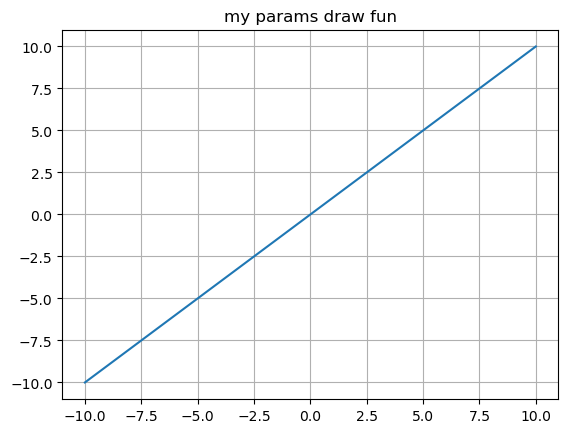

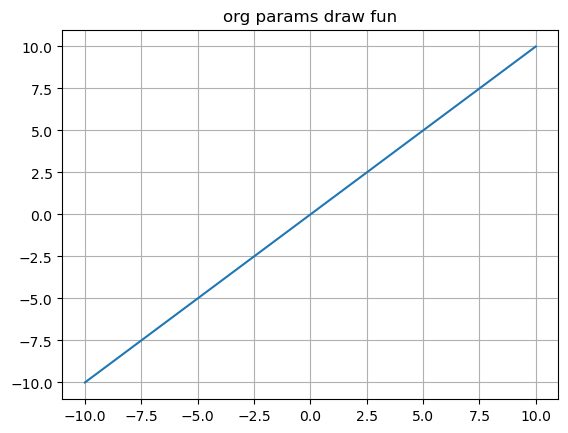

po


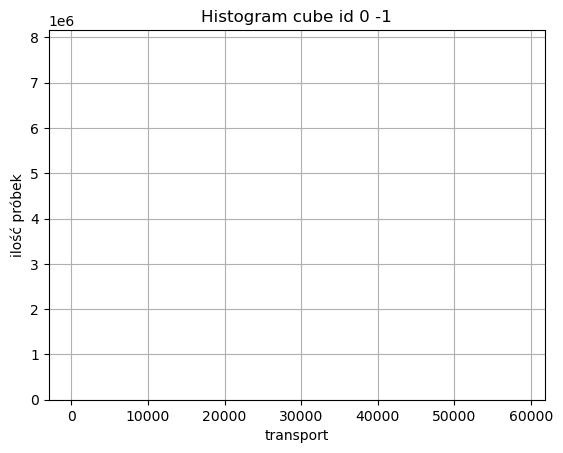

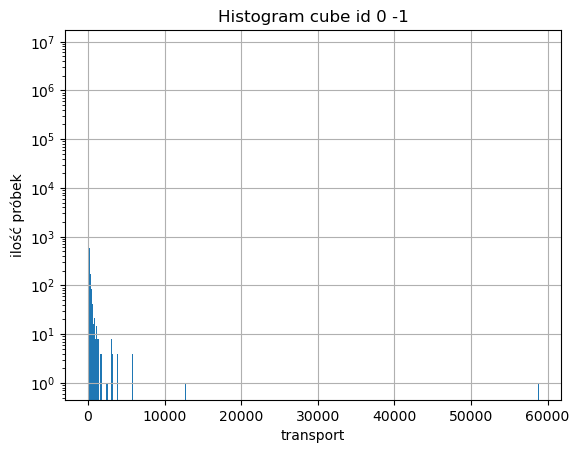

statsmodels.api


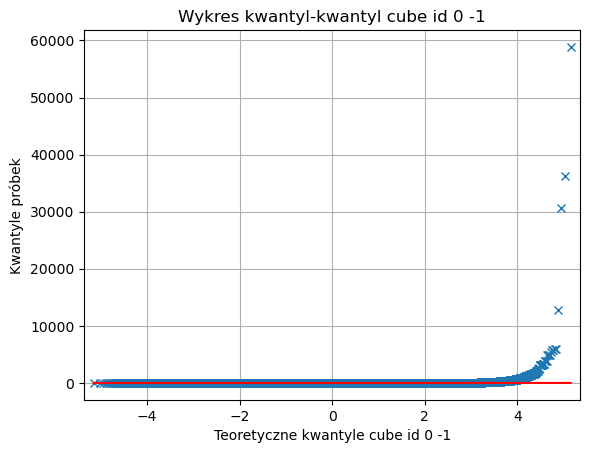

po


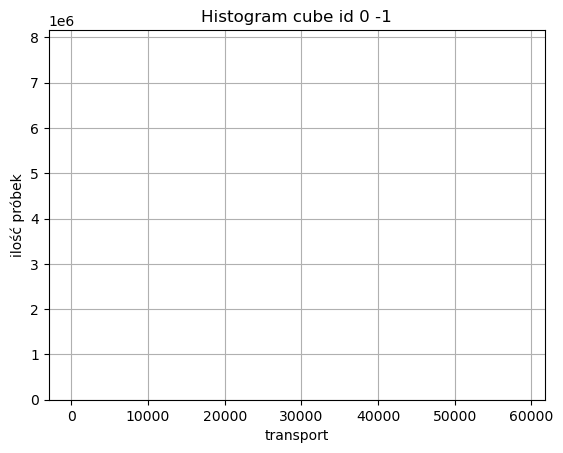

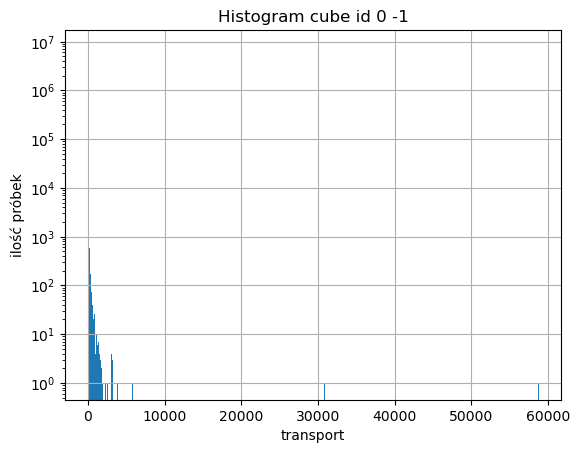

statsmodels.api


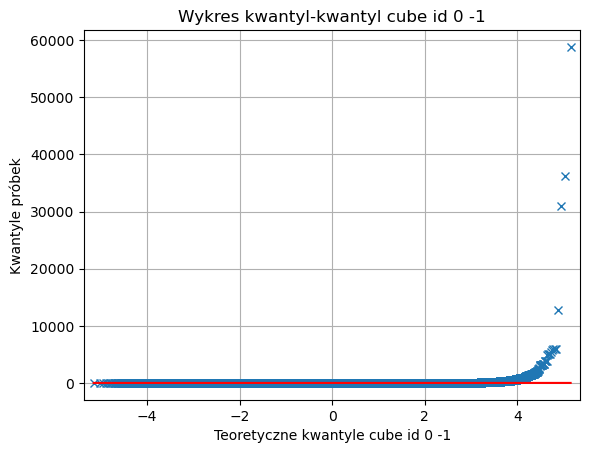

po


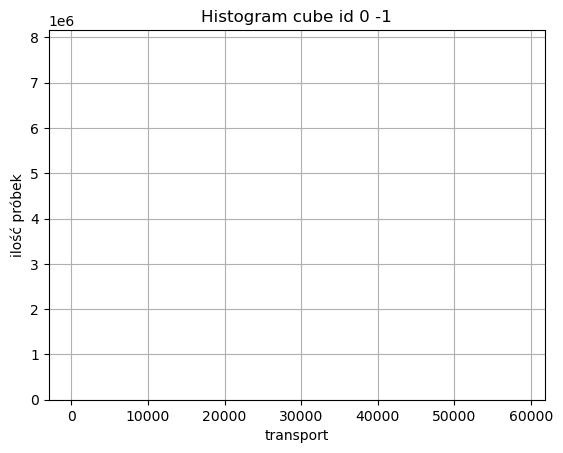

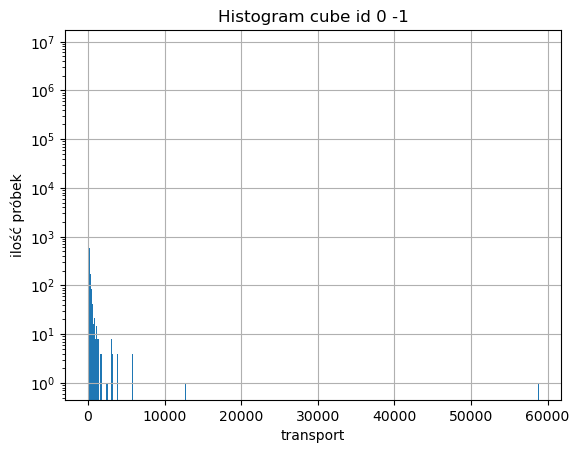

statsmodels.api


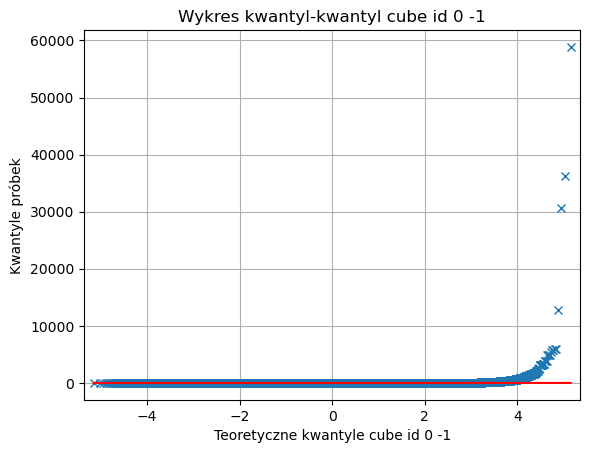

po


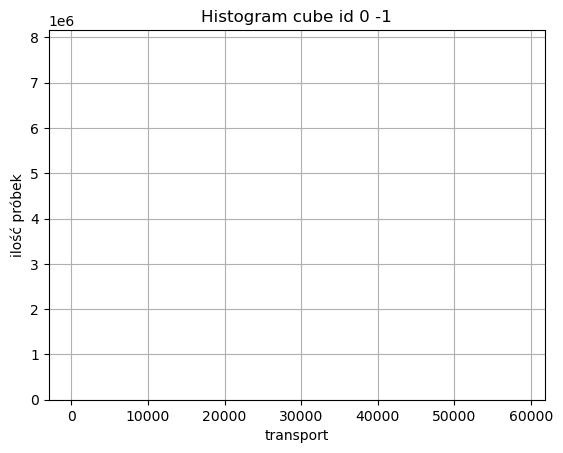

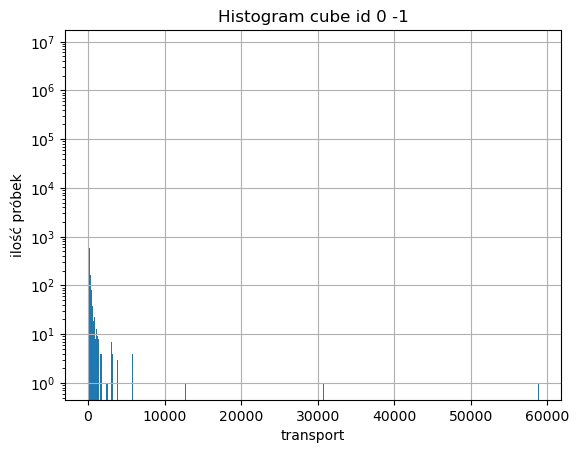

statsmodels.api


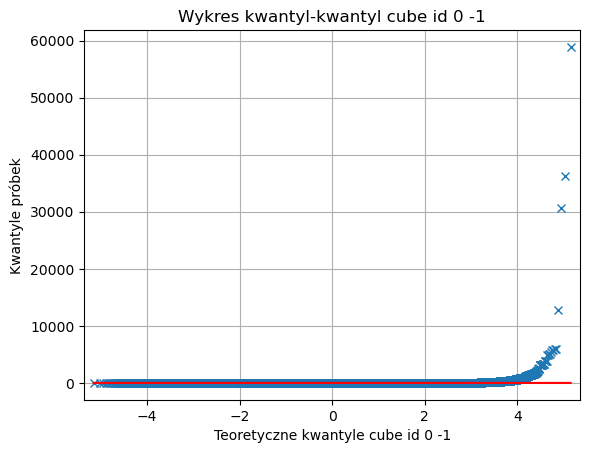

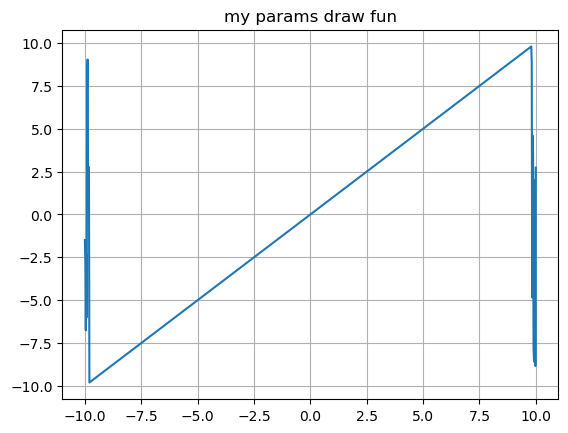

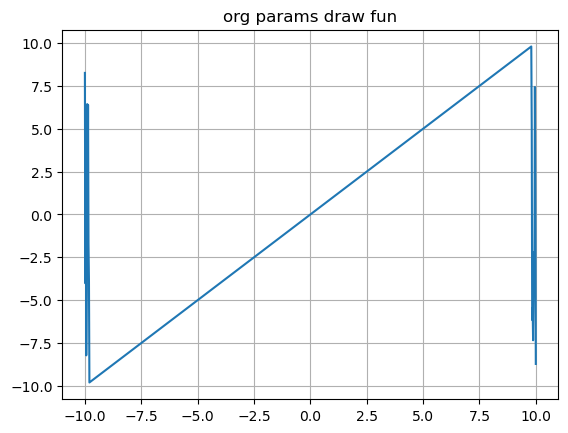

po


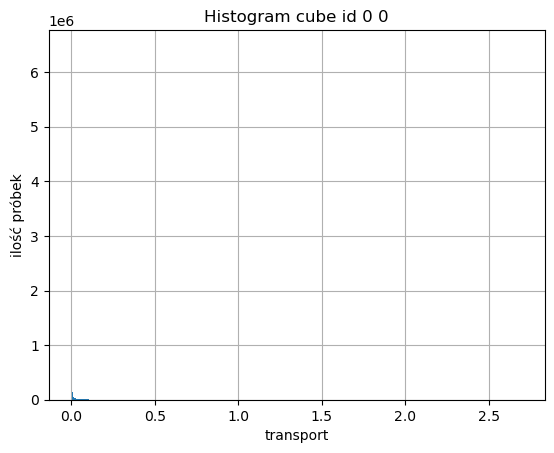

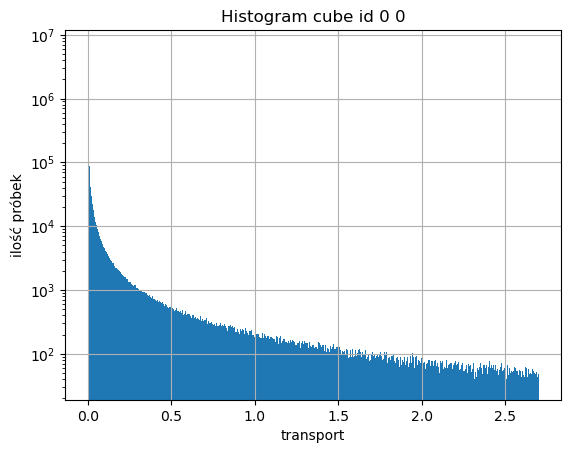

statsmodels.api


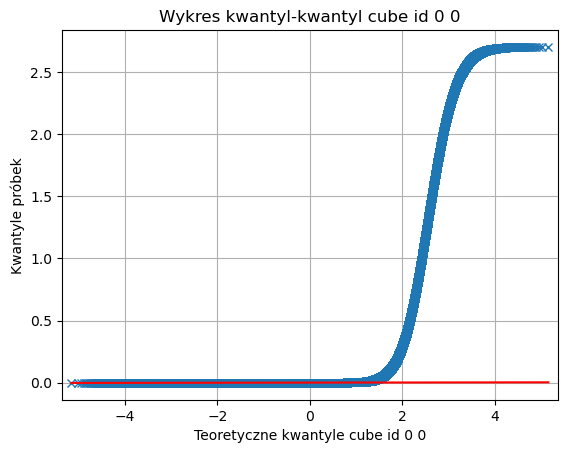

po


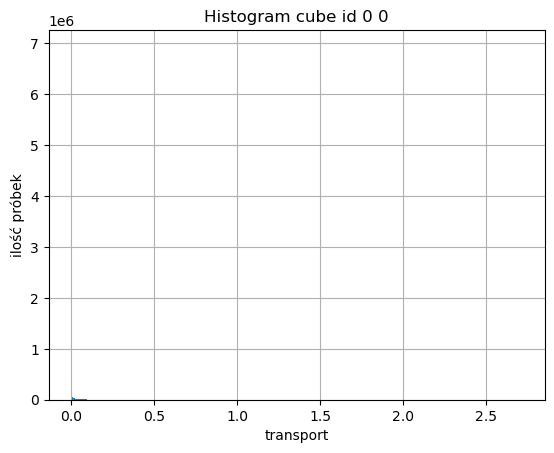

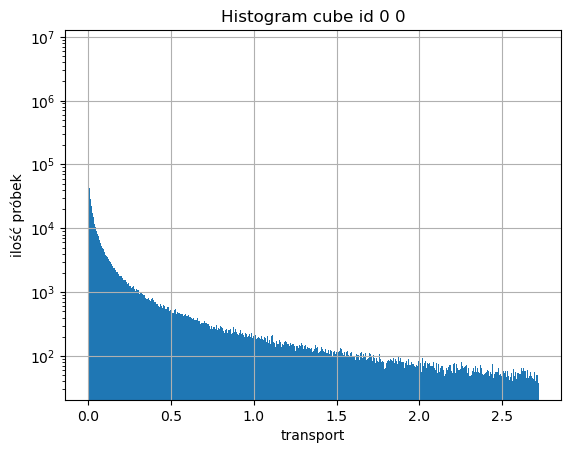

statsmodels.api


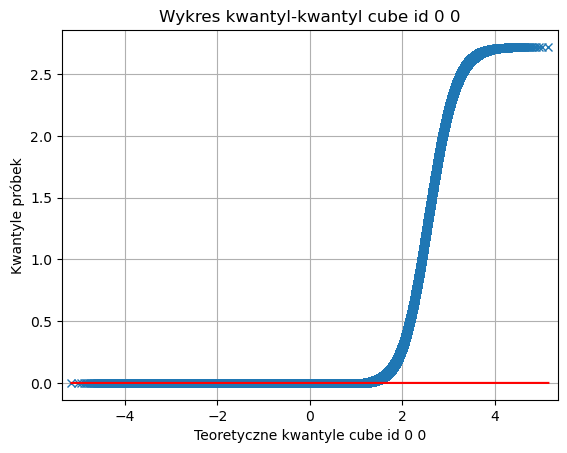

po


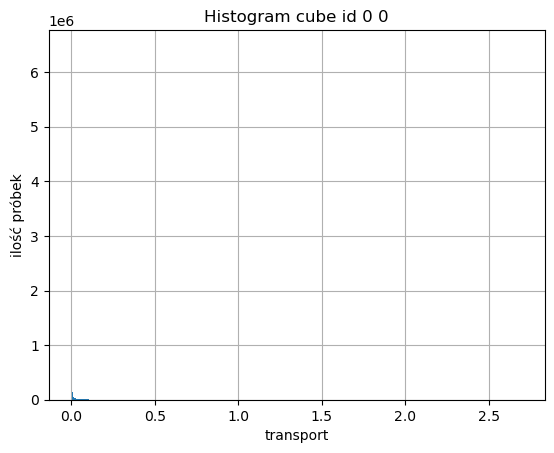

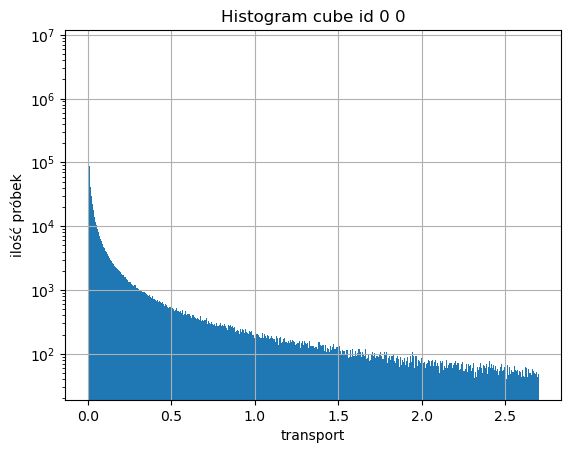

statsmodels.api


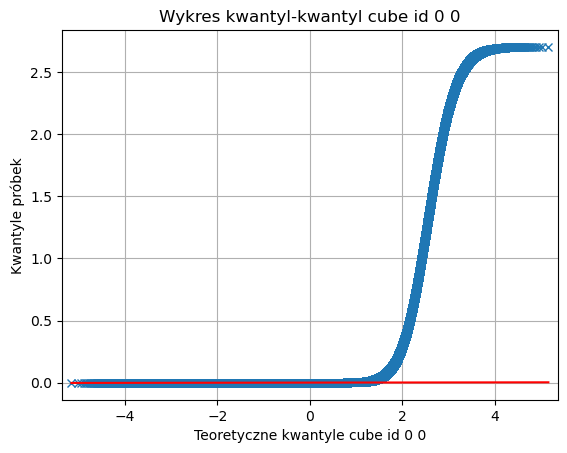

po


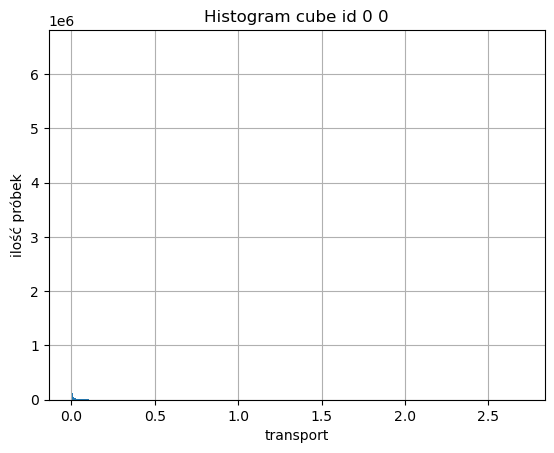

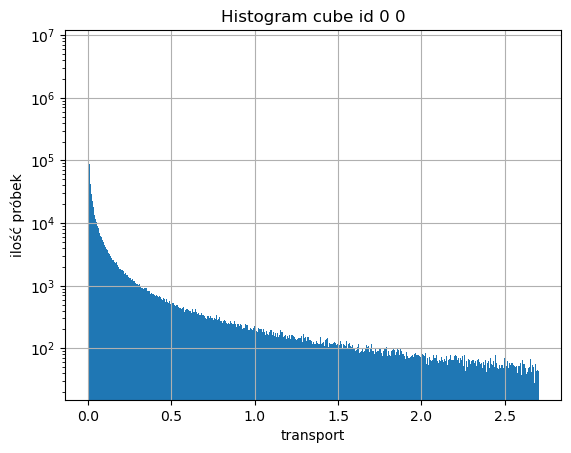

statsmodels.api


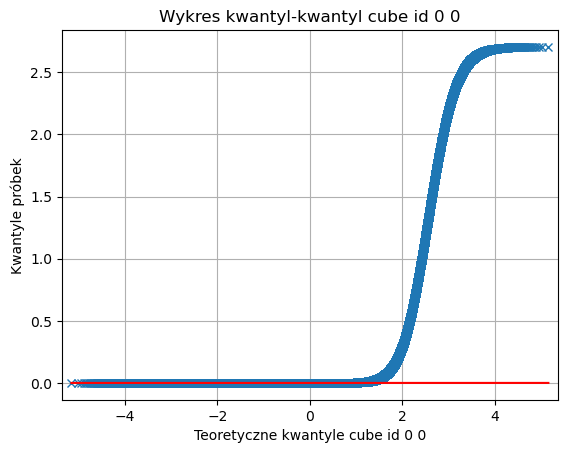

C:\Users\mateu\AppData\Local\Temp\ipykernel_92536\3247585533.py:395: RuntimeWarning: invalid value encountered in log
  arr = np.log(arr) # najlepszy boxcox lambda = 0, więc lepiej logarytm


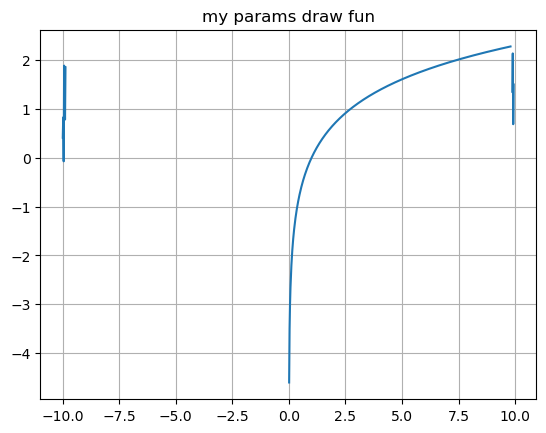

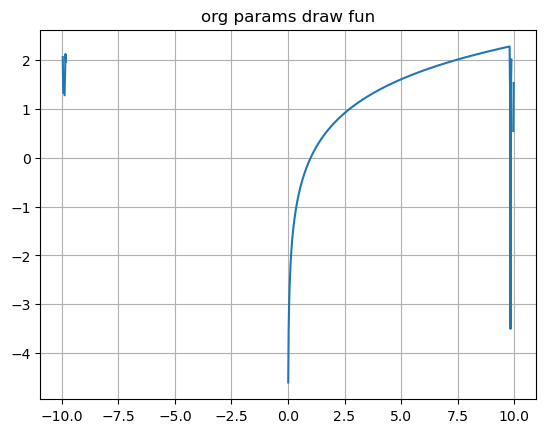

po


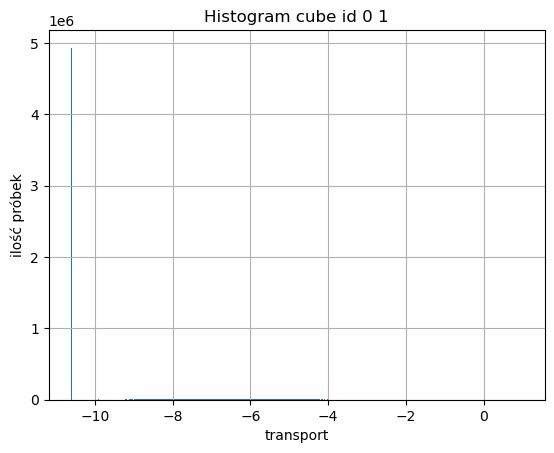

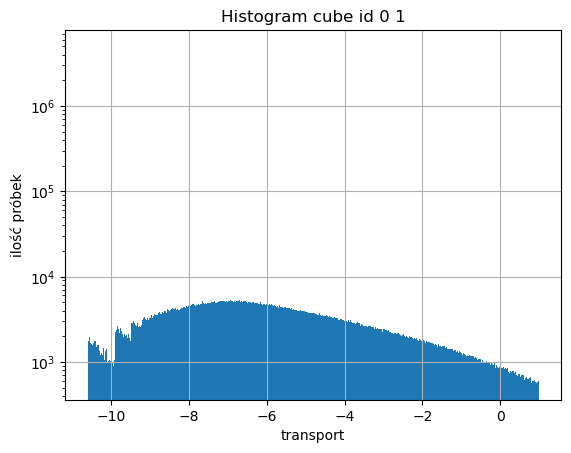

statsmodels.api


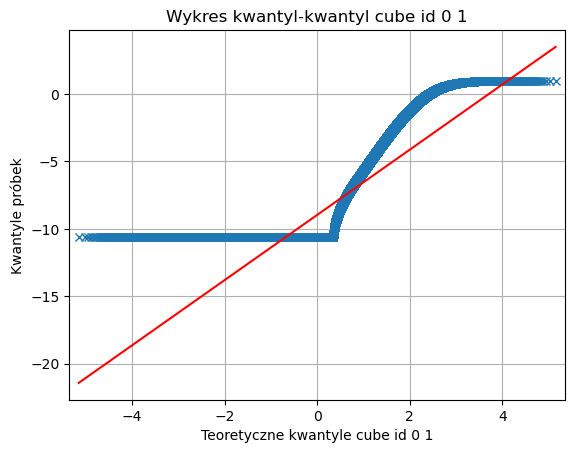

po


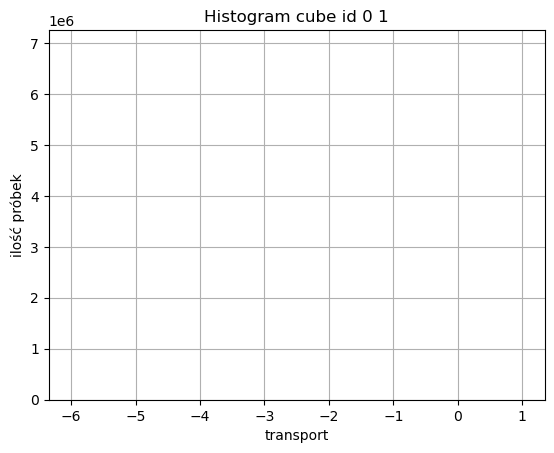

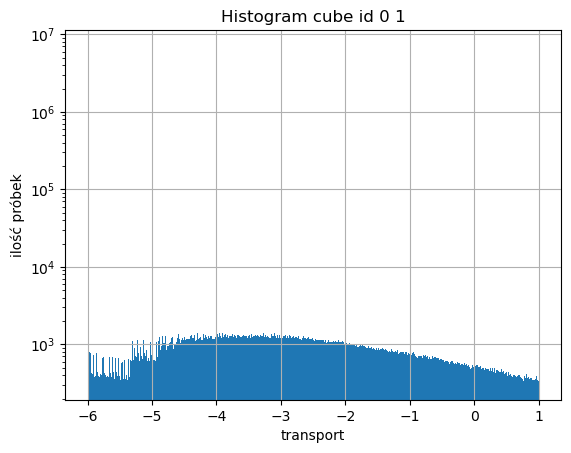

statsmodels.api


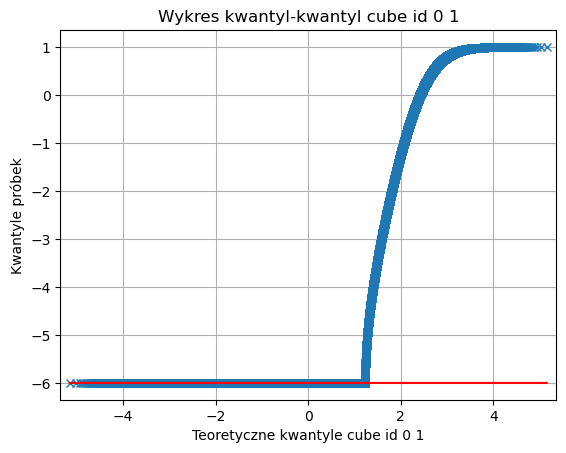

po


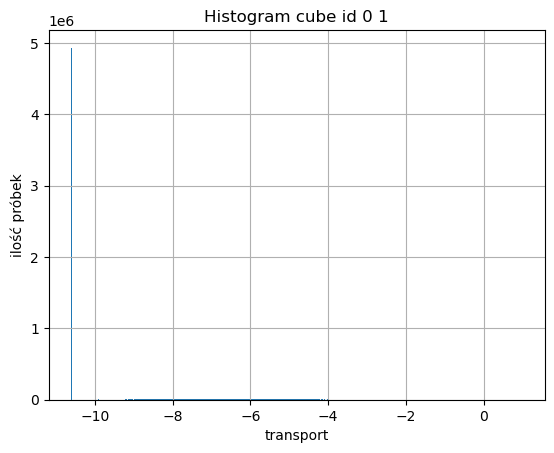

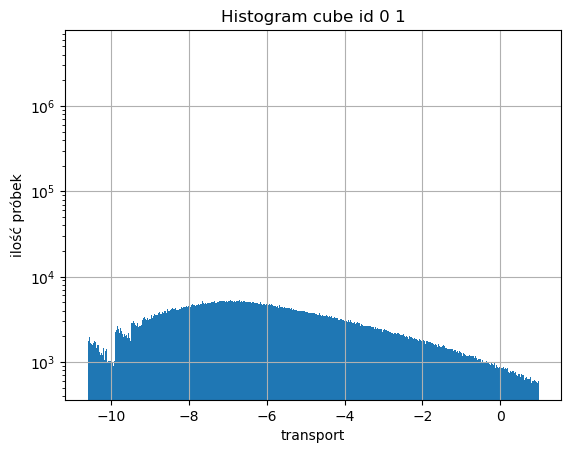

statsmodels.api


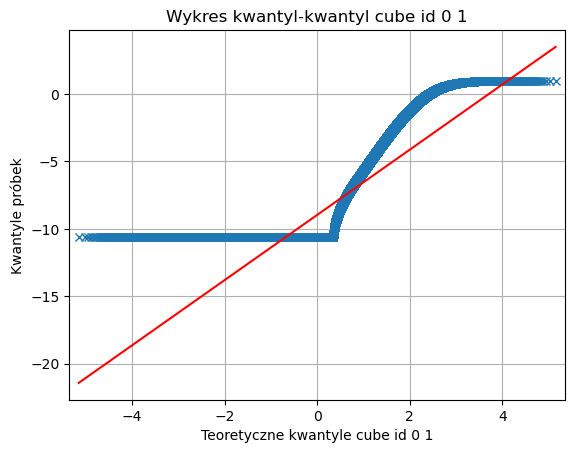

po


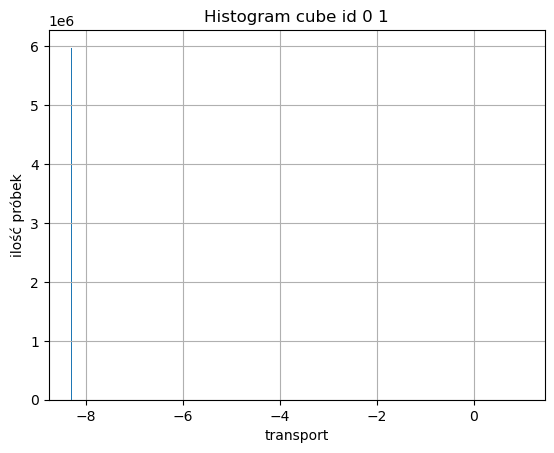

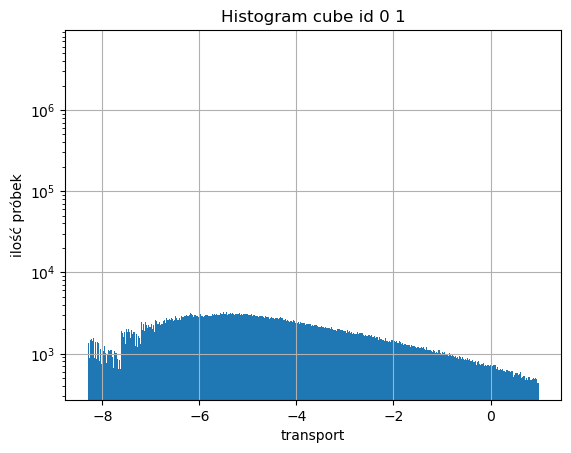

statsmodels.api


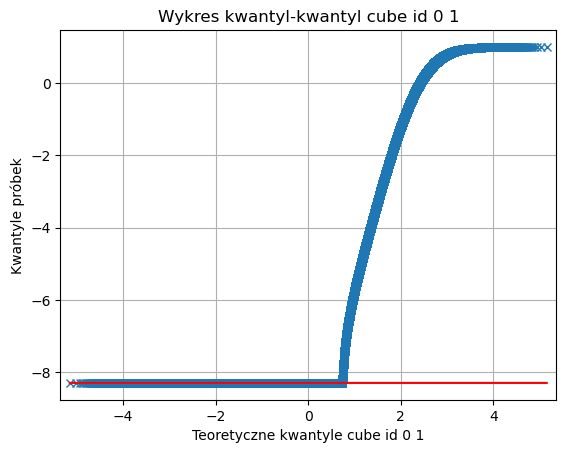

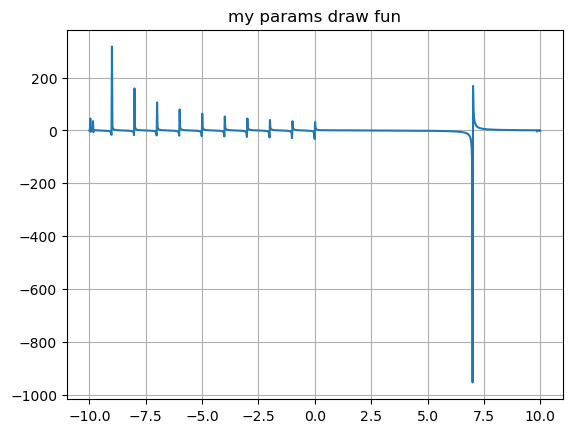

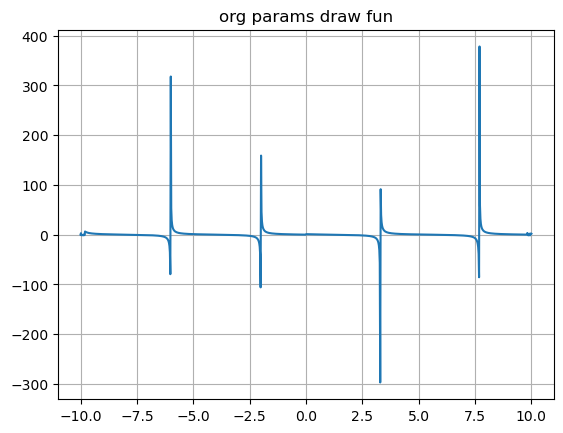

po


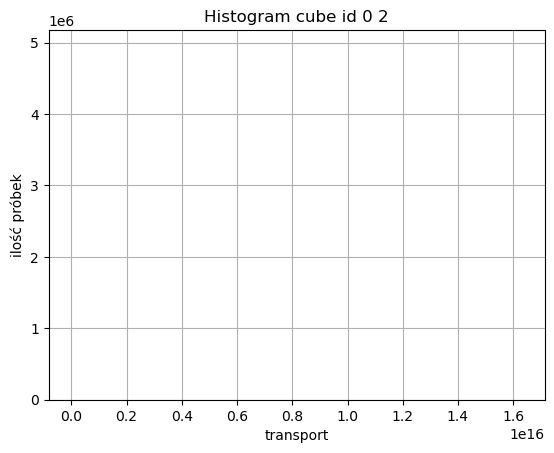

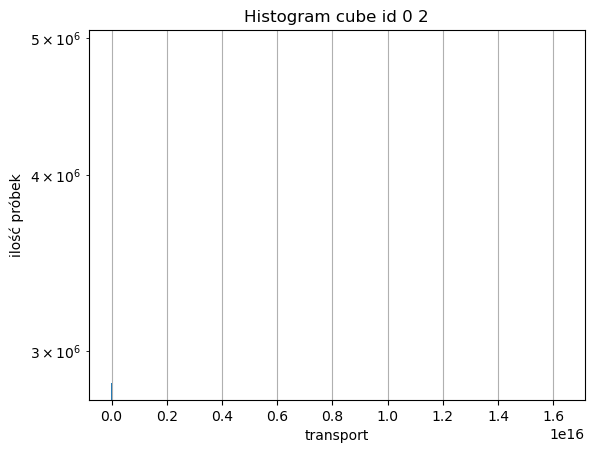

statsmodels.api


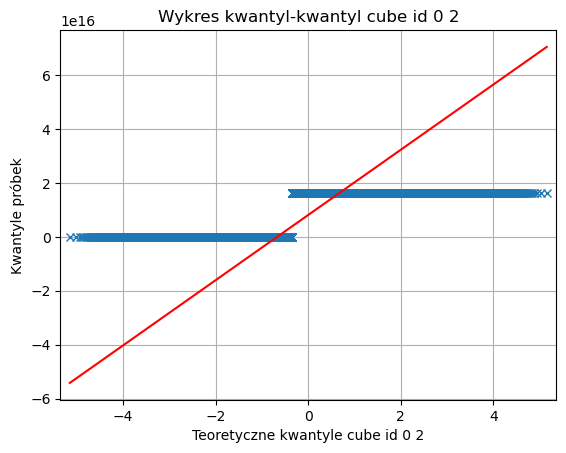

po


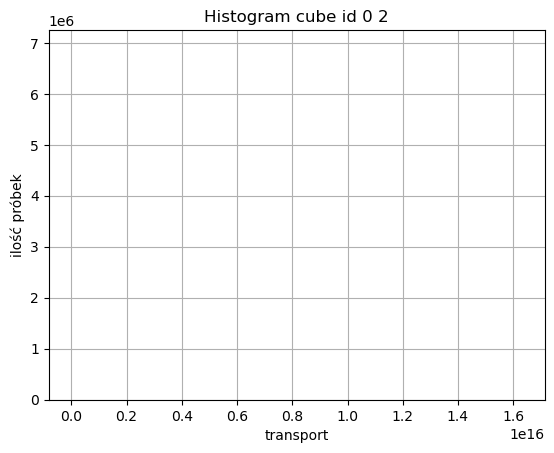

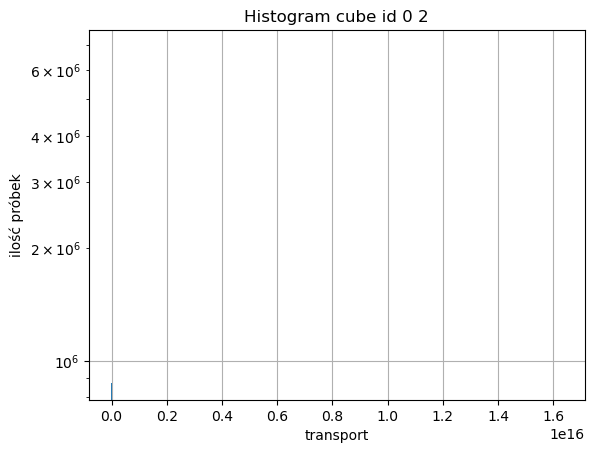

statsmodels.api


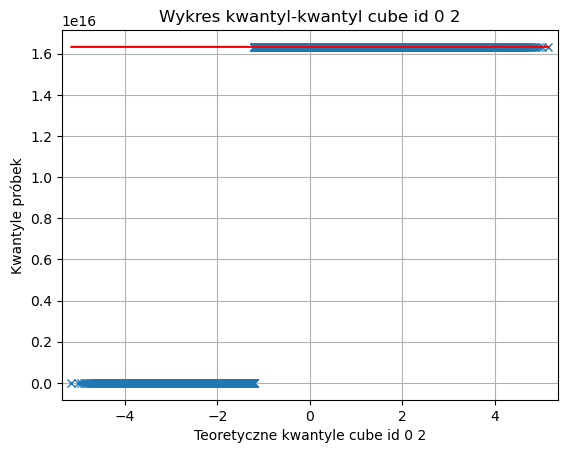

po


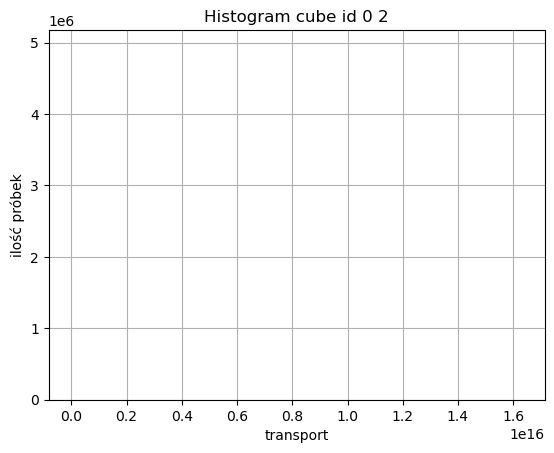

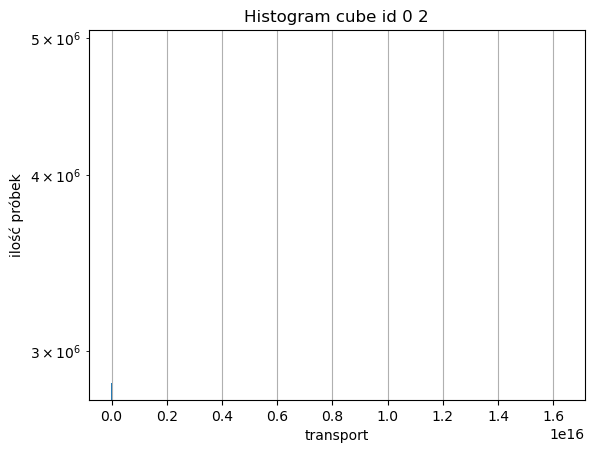

statsmodels.api


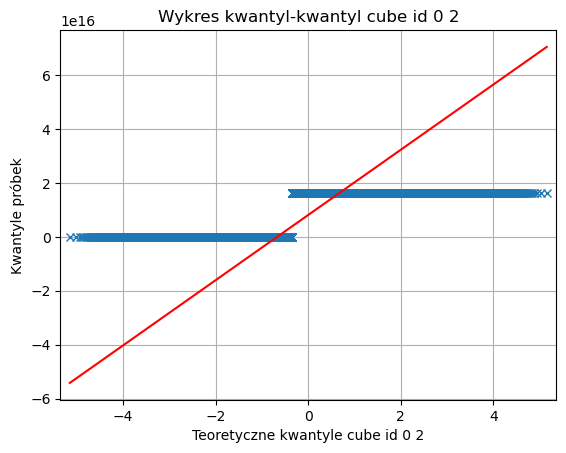

po


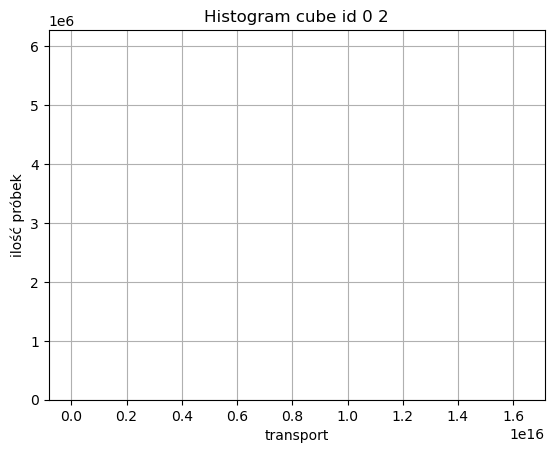

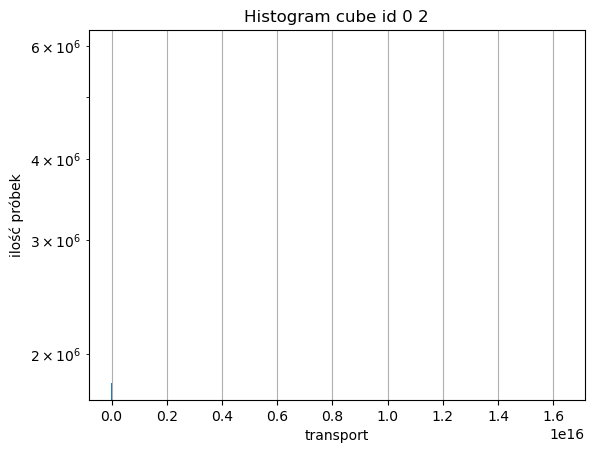

statsmodels.api


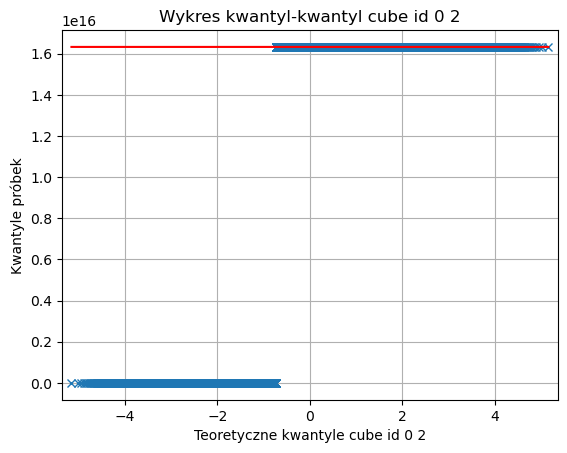

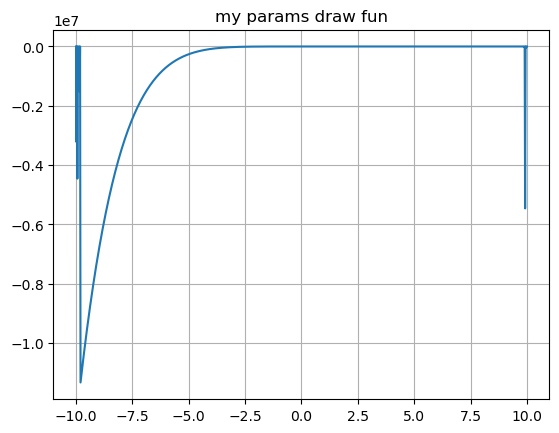

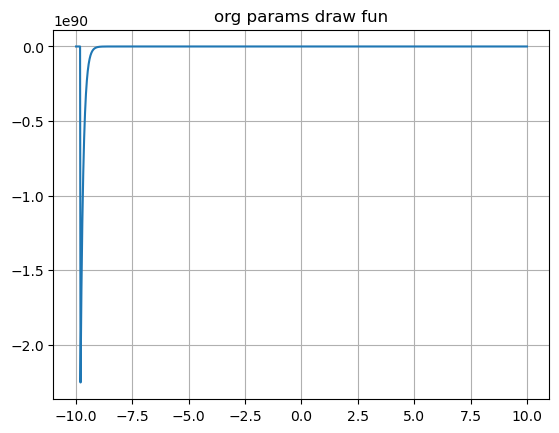

po


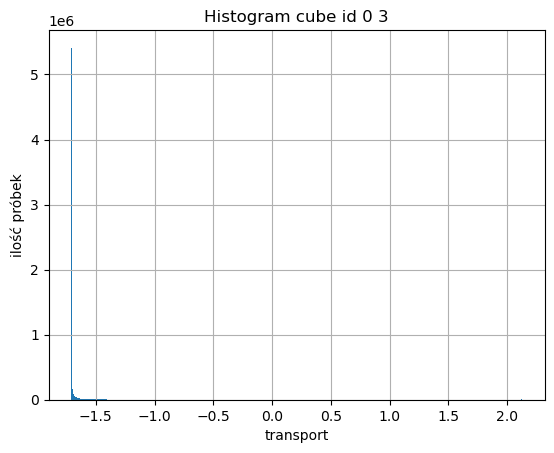

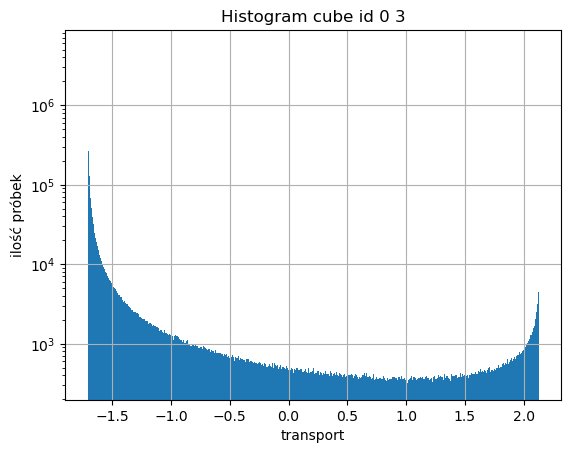

statsmodels.api


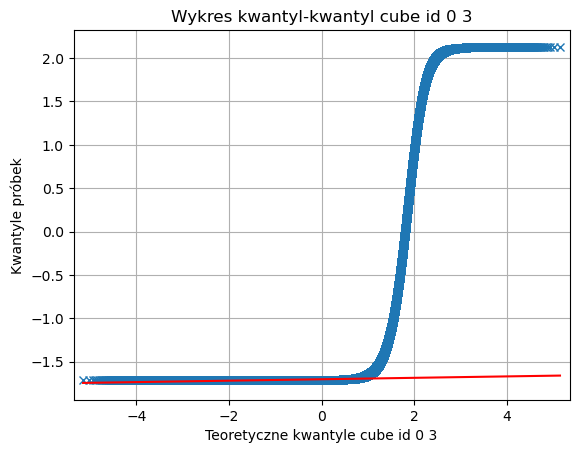

po


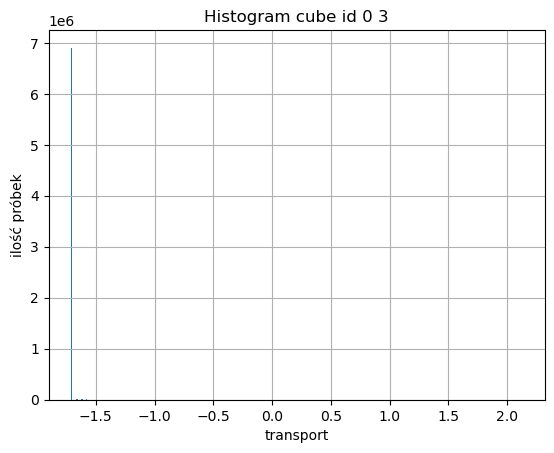

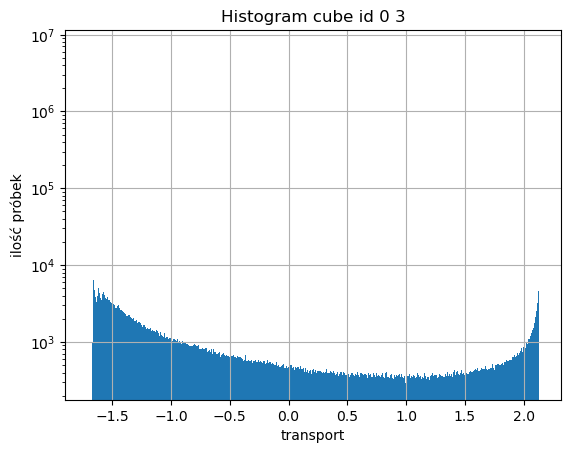

statsmodels.api


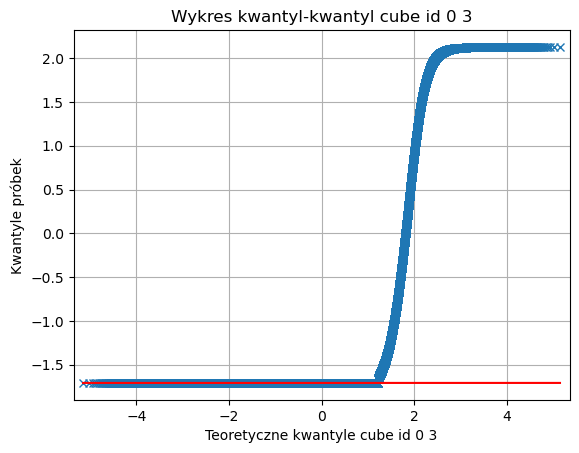

po


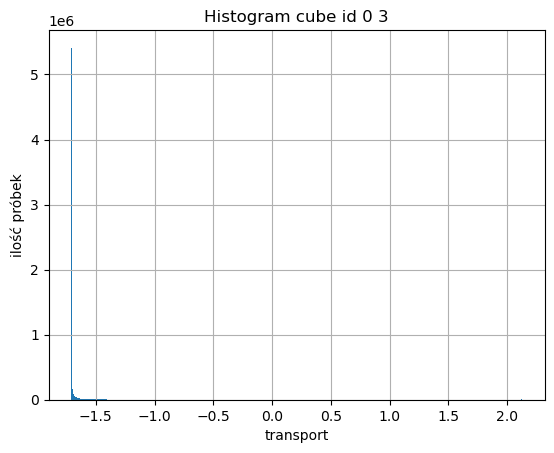

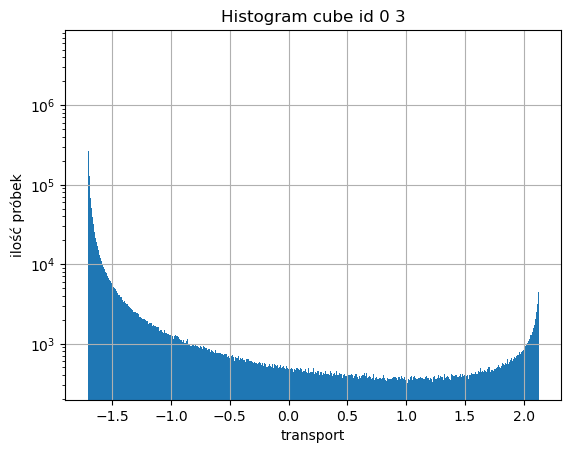

statsmodels.api


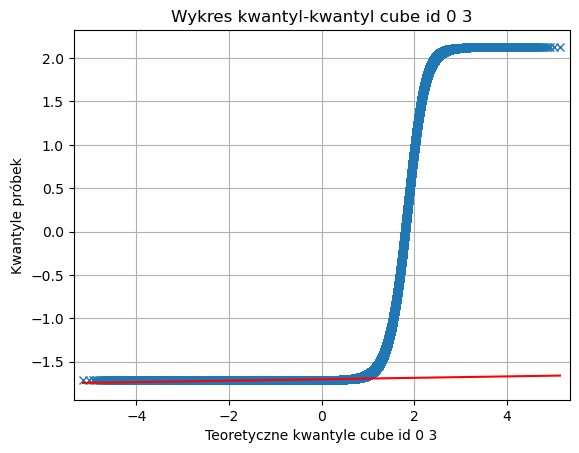

po


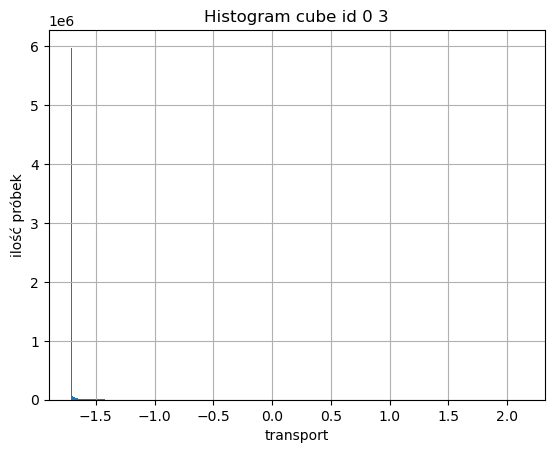

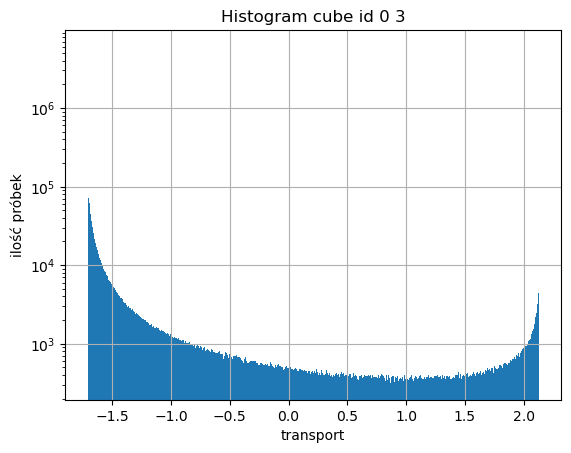

statsmodels.api


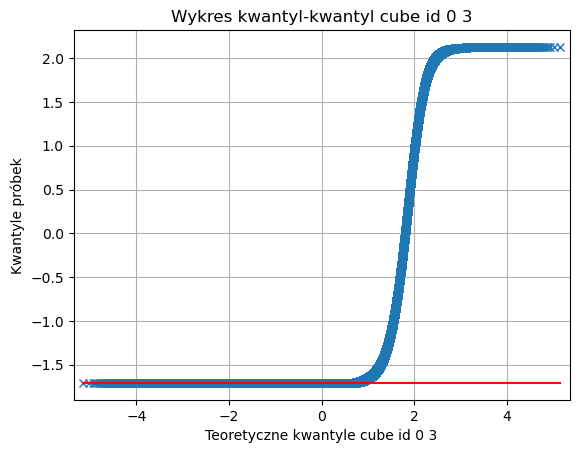

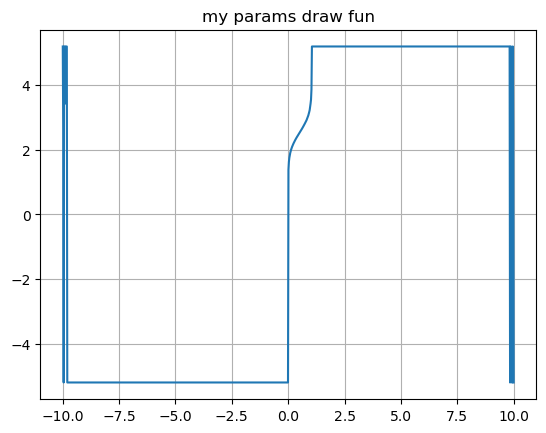

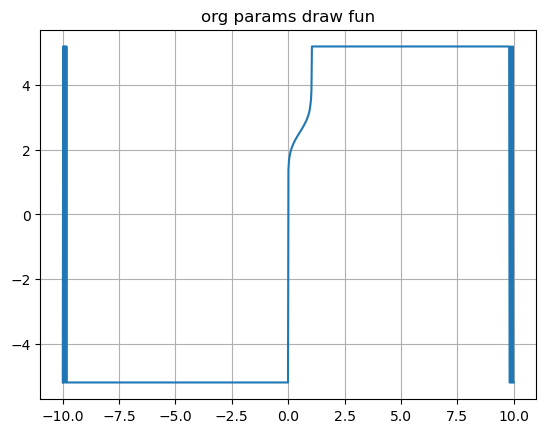

po


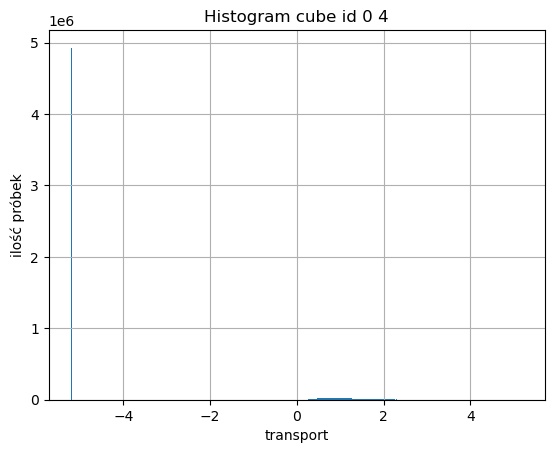

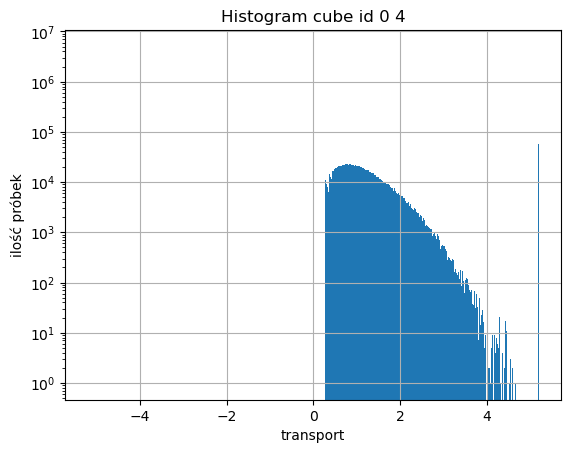

statsmodels.api


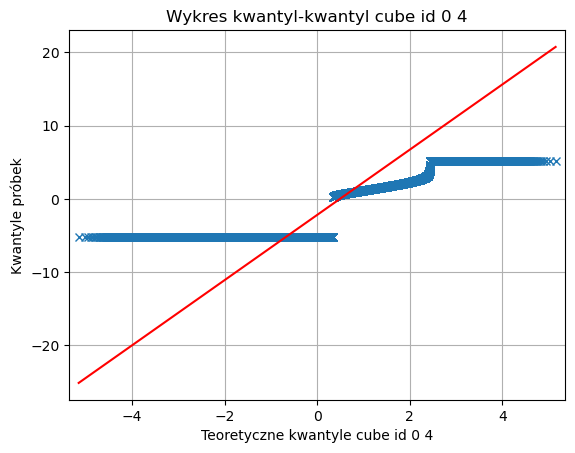

po


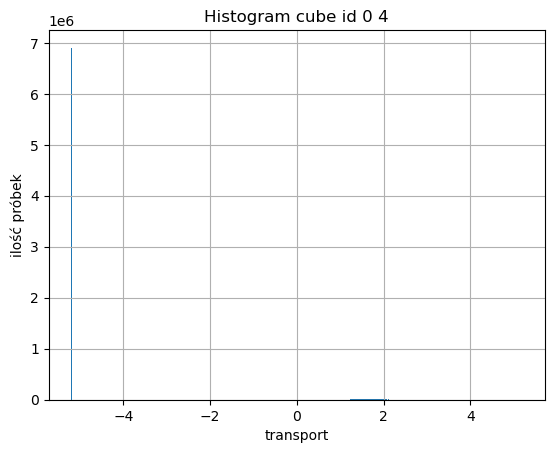

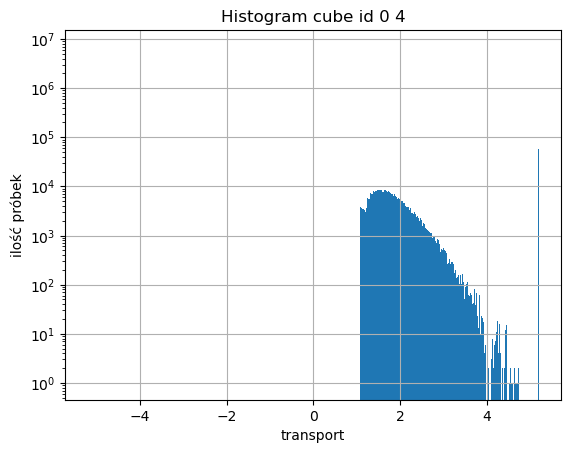

statsmodels.api


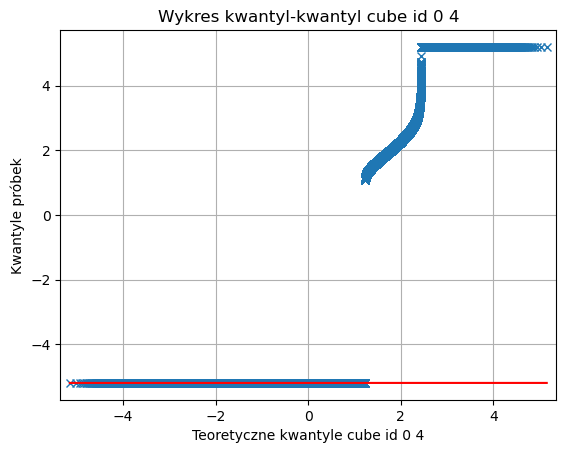

po


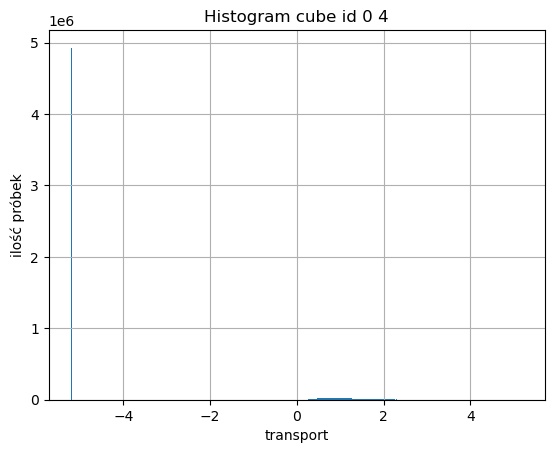

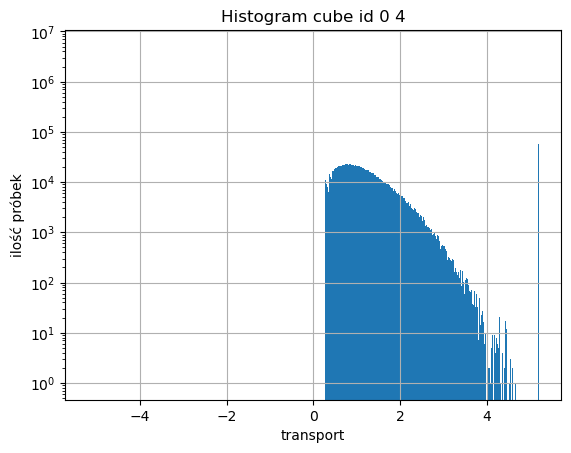

statsmodels.api


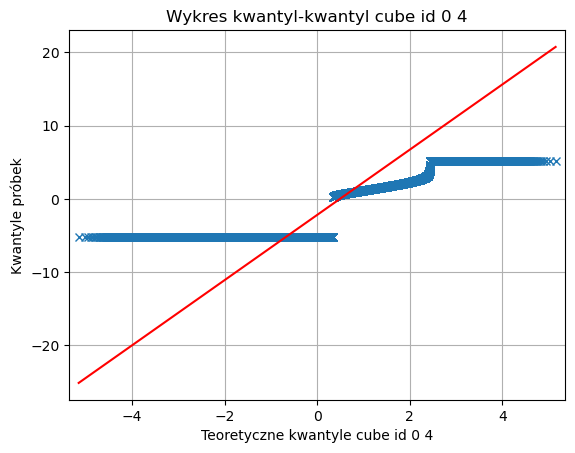

po


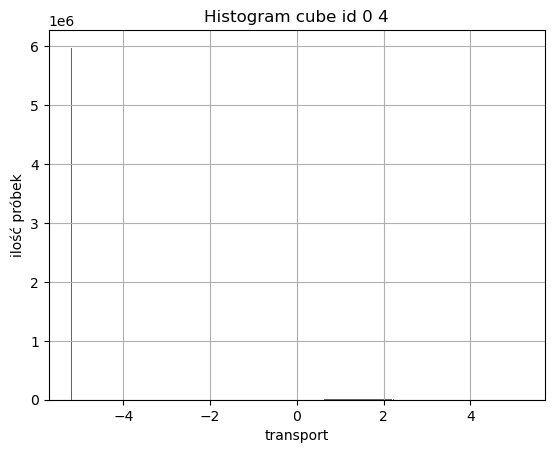

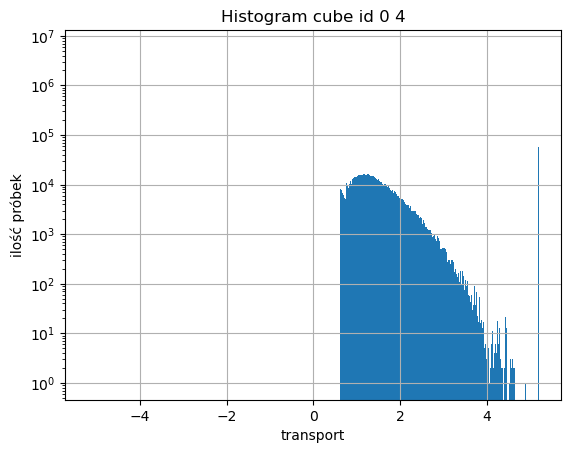

statsmodels.api


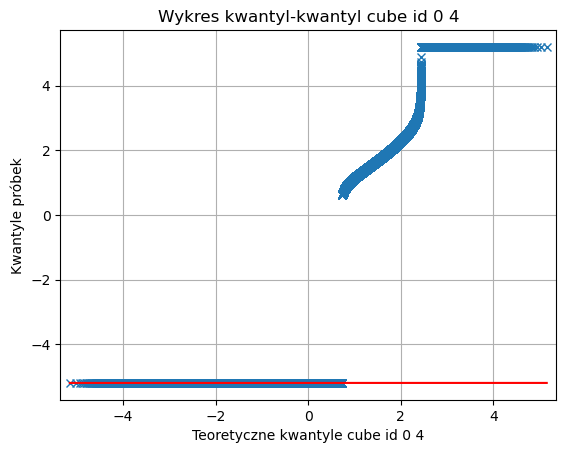

print_all_normal_charts - gotowe
porównanie w tabeli
Comparison * to benchmark (mati-sim 10mln_original_params_cube)
                                                        name                 corr spearman                 pval spearman                        t_stat                        t_pval                        u_stat                        u_pval                chi2_flat_stat                chi2_flat_pval                  chi2_2d_stat                  chi2_2d_pval                  chi2_3d_stat                  chi2_3d_pval                           MSE                          RMSE                      ks_stat1                      ks_pval1                      ks_stat2                      ks_pval2                    ks_test_eq                    ks_pval_eq                   levene_stat                   levene_pval                  corr_pearson                  pval_pearson                    ttind_stat                    ttind_pval                    ttrel_stat             

ValueError: Invalid vmin or vmax

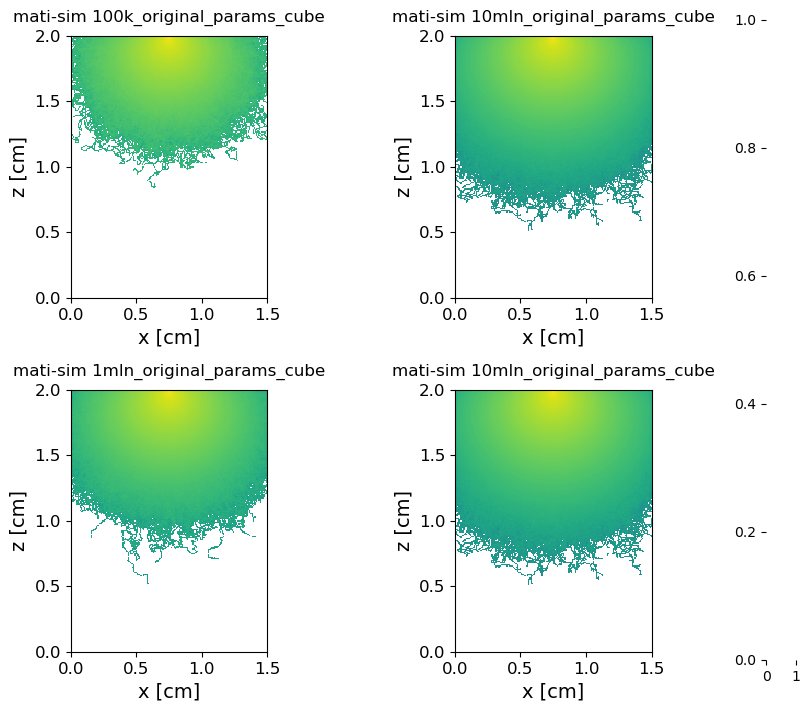

In [80]:
test = experiment(category = 'my demo',
                  experiment_name = '',
                  benchmark_path = ['CUBES', 'mati-sim org_params 10k-10mln', 'mati-sim 10mln_original_params_cube.json'],
                  folders = ['mati-sim org_params 10k-10mln']
                  )
test.get_filenames_from_folders()
test.get_all_cubes_names_from_filenames()
test.mua_per_dir([0.37])
test.params_types_per_dir(['my'])
test.run()

# mati-sim org_params 10k-10mln
# mc456 org_params 10k-100mln

In [81]:
np.log(410)

6.016157159698354

# porównanie python - język c

In [13]:
test = experiment(category = 'porównanie python - język c',
                  experiment_name = '',
                  benchmark_path = ['CUBES', 'mc456 my_params 10k-100mln', 'mc456_mc_100mln_my_params_cube.json'],
                  folders = ['mc456 my_params 10k-100mln', 'mc456_p my-params 10k-10mln']
                  )
test.get_filenames_from_folders()
test.get_all_cubes_names_from_filenames()
test.mua_per_dir([0.37, 0.37])
test.params_types_per_dir(['my', 'my'])
test.run()

# mc456 my_params 10k-100mln
# mc456_p my-params 10k-10mln

mc456 my_params 10k-100mln
mc456_p my-params 10k-10mln
trimming
shape (181, 181, 241)
shape (180, 180, 240)
trimming
shape (181, 181, 241)
shape (180, 180, 240)
trimming
shape (181, 181, 241)
shape (180, 180, 240)
trimming
shape (181, 181, 241)
shape (180, 180, 240)
wczytano z plików
len(all_cubes) 9
7776000
(180, 180, 240)
100000000.00000013
dodano kontrolną próbę losową
shape (180, 180, 240)
size 7776000
len 10
zakończono normalizację


KeyError: 'params_type'

# PORÓWNYWANIE OGÓLNE - my params

In [ ]:
test = experiment(category = 'PORÓWNYWANIE OGÓLNE - my params',
                  experiment_name = '',
                  benchmark_path = ['CUBES', 'mc456 my_params 10k-100mln', 'mc456_mc_100mln_my_params_cube.json'],
                  folders = ['mati-sim my_params 10k-100mln', 'mc456 my_params 10k-100mln']
                  )
test.get_filenames_from_folders()
test.get_all_cubes_names_from_filenames()
test.mua_per_dir([0.37, 0.37])
test.params_types_per_dir(['my', 'my'])
test.run()

# mati-sim my_params 10k-100mln
# mc456 my_params 10k-100mln

# PORÓWNYWANIE OGÓLNE - org params

In [ ]:
test = experiment(category = 'PORÓWNYWANIE OGÓLNE - org params',
                  experiment_name = '',
                  benchmark_path = ['CUBES', 'mc456 org_params 10k-100mln', 'mc456_mc_100mln_org_params_cube.json'],
                  folders = ['mati-sim org_params 10k-10mln', 'mc456 org_params 10k-100mln']
                  )
test.get_filenames_from_folders()
test.get_all_cubes_names_from_filenames()
test.mua_per_dir([1.673, 1.673])
test.params_types_per_dir(['org', 'org'])
test.run()

# mati-sim org_params 10k-10mln
# mc456 org_params 10k-100mln

# specjalistyczne mc456 rozne g (0.0-1.0 z krokiem 0.1) 100mln

In [ ]:
test = experiment(category = 'specjalistyczne mc456 rozne g (0.0-1.0 z krokiem 0.1) 100mln',
                  experiment_name = '',
                  benchmark_path = ['CUBES', 'mc456 rozne g (0.0-1.0 z krokiem 0.1) 100mln', 'mc456_mc_100mln_my_params_tiss_id_4_g_0_9__cube.json'],
                  folders = ['mc456 rozne g (0.0-1.0 z krokiem 0.1) 100mln']
                  )
test.get_filenames_from_folders()
test.get_all_cubes_names_from_filenames()
test.mua_per_dir([0.37])
test.params_types_per_dir(['my'])
test.run()

# mc456 rozne g (0.0-1.0 z krokiem 0.1) 100mln

# specjalistyczne mati-sim my_params 10k g {0, 0.5, 0.9, 1}

In [ ]:
test = experiment(category = 'specjalistyczne mati-sim my_params 10k g {0, 0.5, 0.9, 1}',
                  experiment_name = '',
                  benchmark_path = ['CUBES', 'mati-sim my_params 10k g {0, 0.5, 0.9, 1}', 'mati-sim my_params 10k g_0_9_cube.json'],
                  folders = ['mati-sim my_params 10k g {0, 0.5, 0.9, 1}'],
                  )
test.get_filenames_from_folders()
test.get_all_cubes_names_from_filenames()
test.mua_per_dir([0.37])
test.params_types_per_dir(['my'])
test.run()


# mati-sim my_params 10k g {0, 0.5, 0.9, 1}

# specjalistyczne mc456 rozne_skóry_z_tabeli (8 rodzajów) 100mln

In [ ]:
test = experiment(category = 'specjalistyczne mc456 rozne_skóry_z_tabeli (8 rodzajów) 100mln',
                  experiment_name = '',
                  benchmark_path = ['CUBES', 'mc456 rozne_skóry_z_tabeli (8 rodzajów) 100mln', 'mc456_mc_100mln_my_params_tiss_id_4_cube.json'],
                  folders = ['mc456 rozne_skóry_z_tabeli (8 rodzajów) 100mln'],
                  )
test.get_filenames_from_folders()
test.get_all_cubes_names_from_filenames()
test.mua_from_file()
test.params_types_per_dir(['my'])
test.run()

# mc456 rozne_skóry_z_tabeli (8 rodzajów) 100mln

# specjalistyczne mc456 my-params light-sources

In [ ]:
test = experiment(category = 'specjalistyczne mc456 my-params light-sources',
                  experiment_name = '',
                  benchmark_path = ['CUBES', 'mc456 my-params light-sources', 'mc456_mc_100mln_my_params_tiss_id_4_g_0_9_ls_down_cube.json'],
                  folders = ['mc456 my-params light-sources'],
                  )
test.get_filenames_from_folders()
test.get_all_cubes_names_from_filenames()
test.mua_per_dir([0.37])
test.params_types_per_dir(['my'])
test.run()

# mc456 my-params light-sources

# dodatkowe mati-sim 2-layers

In [ ]:
test = experiment(category = 'dodatkowe mati-sim 2-layers',
                  experiment_name = '',
                  benchmark_path = ['CUBES', 'mati-sim 2-layers', 'mati-sim 2-layers 1_000_000_photons_cube.json'],
                  folders = ['mati-sim 2-layers'],
                  )
test.get_filenames_from_folders()
test.get_all_cubes_names_from_filenames()
test.mua_per_dir([0.37])
test.params_types_per_dir(['my'])
test.run()

# mati-sim 2-layers

# dodatkowe mati-sim 3-layers

In [ ]:
test = experiment(category = 'dodatkowe mati-sim 3-layers',
                  experiment_name = '',
                  benchmark_path = ['CUBES', 'mati-sim 3-layers', 'mati-sim 3-layers 1_000_000_cube.json'],
                  folders = ['mati-sim 3-layers'],
                  )
test.get_filenames_from_folders()
test.get_all_cubes_names_from_filenames()
test.mua_per_dir([0.37])
test.params_types_per_dir(['my'])
test.run()

# mati-sim 3-layers

# dodatkowe mati-sim veins

In [ ]:
test = experiment(category = 'dodatkowe mati-sim veins',
                  experiment_name = '',
                  benchmark_path = ['CUBES', 'mati-sim veins', 'mati-sim veins 100_000_fotonów_cube.json'],
                  folders = ['mati-sim veins'],
                  )
test.get_filenames_from_folders()
test.get_all_cubes_names_from_filenames()
test.mua_per_dir([0.37])
test.params_types_per_dir(['my'])
test.run()

# mati-sim veins

# inne

In [3]:
os.listdir('CUBES')

['mati-sim 2-layers',
 'mati-sim 3-layers',
 'mati-sim my_params 10k g {0, 0.5, 0.9, 1}',
 'mati-sim my_params 10k-100mln',
 'mati-sim org_params 10k-10mln',
 'mati-sim veins',
 'mc456 my-params light-sources',
 'mc456 my_params 10k-100mln',
 'mc456 org_params 10k-100mln',
 'mc456 rozne g (0.0-1.0 z krokiem 0.1) 100mln',
 'mc456 rozne_skóry_z_tabeli (8 rodzajów) 100mln',
 'mc456_p my-params 10k-10mln']

In [4]:
[123]*4

[123, 123, 123, 123]

In [ ]:
# porównanie python - język c:

# mc456 my_params 10k-100mln
# mc456_p my-params 10k-10mln




# PORÓWNYWANIE OGÓLNE:

# mati-sim my_params 10k-100mln
# mc456 my_params 10k-100mln

# mati-sim org_params 10k-10mln
# mc456 org_params 10k-100mln



# specjalistyczne:

# mc456 rozne g (0.0-1.0 z krokiem 0.1) 100mln

# mati-sim my_params 10k g {0, 0.5, 0.9, 1}

# mc456 rozne_skóry_z_tabeli (8 rodzajów) 100mln

# mc456 my-params light-sources



# dodatkowe:

# mati-sim 2-layers

# mati-sim 3-layers

# mati-sim veins